# PSP Automated Magnetic Hole Finder
## By: Robert Alexander + Jaye Verniero


### 0.1) Import Packages, Define Helper Functions, and Set Save Directory

In [1]:
# --- Plotbot Imports and Configuration ---
try:
    from plotbot import print_manager as pm
    # Set these to True if you want to see detailed logs from Plotbot's core & magnetic_hole_finder_core
    pm.show_error = True
    pm.show_warnings = True
    pm.show_status = True # To see status messages from the core function
    pm.show_debug = True  # To see [MH_DM_DEBUG] and other debugs from core
    pm.show_datacubby = False # Or True if debugging DataCubby
    pm.show_processing = False # Or True for Plotbot processing steps
    print("Successfully imported and configured Plotbot's print_manager.")
except ImportError:
    print("Could not import Plotbot's print_manager...")
    pm = None

# --- Local Application Imports (magnetic_hole_finder) ---
# We only need the main orchestrator function and the settings class now from the core
from magnetic_hole_finder.magnetic_hole_finder_core import HoleFinderSettings, detect_magnetic_holes_and_generate_outputs
from collections import Counter # For understanding the returned counter object if needed

# Other imports that might be used *only* in the notebook for ad-hoc stuff (if any)
# Most of these (numpy, pandas, datetime, json, os) are now primarily used within the .py files
import numpy as np 
import pandas as pd
import json
import os
from datetime import datetime 

# --- Warnings Handling Configuration ---
from warnings import simplefilter
import warnings
simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="IPython.core.pylabtools")

current_time_consolidated = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f'{current_time_consolidated} - 📚 All libraries imported and environment configured.')

initialized server_access
initialized global_tracker
initialized ploptions
initialized plot_manager
initialized mag_rtn_4sa class
initialized mag_rtn class
initialized mag_sc_4sa class
initialized mag_sc class
initialized epad class
initialized epad_hr class
initialized proton class
initialized proton_hr class
initialized data_cubby
initialized proton_fits class
initialized ham_class
🔉 initialized audifier

Importing libraries, this may take a moment. Hold tight... 

✅ Imported standard libraries and utilities.
✅ Imported numpy, pandas, and scipy libraries.
✅ Imported matplotlib libraries.
✅ Imported cdflib, BeautifulSoup, requests, dateutil, and datetime libraries.

🤖 Plotbot Initialized
✨ Showdahodo initialized
Positional Data Helper Initialized
📈📉 Multiplot Initialized
   Version: 2025_05_06_v2.23
Commit: fix: Vertical line at x=0 in degrees_from_perihelion mode (v2.23)

🤖 Plotbot Initialized
Successfully imported and configured Plotbot's print_manager.
2025-05-06 15:35:02.419 - ⏱️ 

In [2]:
import os # Ensure os is imported

# Define the main directory where all outputs will go
# This is what the user might change.
BASE_SAVE_DIRECTORY = os.path.abspath("MH_Scan_Output") # Path relative to project root
os.makedirs(BASE_SAVE_DIRECTORY, exist_ok=True) # Create it if it doesn't exist
print(f'🛟 Algorithm output base directory set to: {BASE_SAVE_DIRECTORY}')

🛟 Algorithm output base directory set to: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output


In [3]:
#Cell 2
# --- Hardcode the base directory for algorithm outputs ---
import os # Ensure os is imported if not already
save_dir = os.path.abspath("MH_Scan_Output") # Path relative to project root
os.makedirs(save_dir, exist_ok=True)       # Create it if it doesn't exist
print(f'🛟 Algorithm output directory (save_dir) set to: {save_dir}')

🛟 Algorithm output directory (save_dir) set to: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output


In [4]:
# Cell 3: Configure HoleFinderSettings for the Run

# Instantiate settings with defaults from the class
mh_run_settings = HoleFinderSettings()

# === Customize parameters for THIS SPECIFIC RUN ===
# Values shown here are examples if you want to override the defaults 
# defined in the HoleFinderSettings class. If the default is fine, you don't need to set it here.

# --- Core Algorithm Parameters ---
mh_run_settings.INSTRUMENT_SAMPLING_RATE = 292.9 
mh_run_settings.use_calculated_sampling_rate = True
mh_run_settings.depth_percentage_threshold = 0.25
mh_run_settings.smoothing_window_seconds = 8.0
mh_run_settings.derivative_window_seconds = 0.2
mh_run_settings.min_max_finding_smooth_window = 0.3
mh_run_settings.mean_threshold = 0.8
mh_run_settings.search_in_progress_output = True  # For verbose logging during detection
mh_run_settings.additional_seconds_for_min_search = 0.2
mh_run_settings.asymetric_peak_threshold = 0.25
mh_run_settings.symmetrical_peak_scan_window_in_secs = 2.0
mh_run_settings.Bave_scan_seconds = 0.1
mh_run_settings.Bave_window_seconds = 20.0
mh_run_settings.wide_angle_threshold = 15.0
mh_run_settings.small_threshold_cross_flag_samples = 10
mh_run_settings.small_threshold_cross_adjustment_samples = 10

# --- Algorithm Breaking Condition Flags ---
mh_run_settings.break_for_shallow_hole = True
mh_run_settings.break_for_assymettry = False 
mh_run_settings.break_for_wide_angle = False 
mh_run_settings.break_for_small_threshold_cross = False
mh_run_settings.break_for_complex_hole = False 
mh_run_settings.threshold_for_derivative_0_crossings_flag = 1000
mh_run_settings.break_for_derivative_crossings = False

# --- Output Generation Control Flags (for outputs handled by the core .py function) ---
mh_run_settings.OUTPUT_MAIN_PLOT = True 
mh_run_settings.SAVE_MAIN_PLOT = True   
mh_run_settings.PLOT_HOLE_MINIMUM_ON_MAIN_PLOT = True 
mh_run_settings.PLOT_THRESH_CROSS_ON_MAIN_PLOT = True 

mh_run_settings.OUTPUT_ZERO_CROSSING_PLOT = False # For the specific plot in zero_crossing_analysis

mh_run_settings.IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN = True 
mh_run_settings.IZOTOPE_MARKER_FILE_OUTPUT_GENERAL = False
mh_run_settings.MARKER_FILE_VERSION = 3
mh_run_settings.MARKER_FILES_WITH_ANNOTATED_MARKERS = False
mh_run_settings.MARKER_FILES_WITH_HOLE_NUMBERS = False

mh_run_settings.EXPORT_AUDIO_FILES = True
mh_run_settings.AUDIO_SAMPLING_RATE = 22000

print("HoleFinderSettings configured for this run. Current settings:")
# Pretty print the settings for verification
import json
print(json.dumps(mh_run_settings.__dict__, indent=4))

HoleFinderSettings configured for this run. Current settings:
{
    "INSTRUMENT_SAMPLING_RATE": 292.9,
    "use_calculated_sampling_rate": true,
    "depth_percentage_threshold": 0.25,
    "smoothing_window_seconds": 8.0,
    "derivative_window_seconds": 0.2,
    "min_max_finding_smooth_window": 0.3,
    "mean_threshold": 0.8,
    "search_in_progress_output": true,
    "additional_seconds_for_min_search": 0.2,
    "asymetric_peak_threshold": 0.25,
    "symmetrical_peak_scan_window_in_secs": 2.0,
    "Bave_scan_seconds": 0.1,
    "Bave_window_seconds": 20.0,
    "wide_angle_threshold": 15.0,
    "small_threshold_cross_flag_samples": 10,
    "small_threshold_cross_adjustment_samples": 10,
    "break_for_shallow_hole": true,
    "break_for_assymettry": false,
    "break_for_wide_angle": false,
    "break_for_small_threshold_cross": false,
    "break_for_complex_hole": false,
    "threshold_for_derivative_0_crossings_flag": 1000,
    "break_for_derivative_crossings": false,
    "OUTPUT_MAI

Starting analysis for trange: ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000']...
Outputs will be saved within base directory: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output
Starting magnetic hole detection and output generation for trange: ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000']
Base save directory: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output
Entering setup_output_directory with base_save_dir: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output
Encounter directory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17
Creating encounter directory: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17
Final subdirectory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
Exiting setup_output_directory, returning: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
✅ Outputs for this run will be saved in: /Users/rober

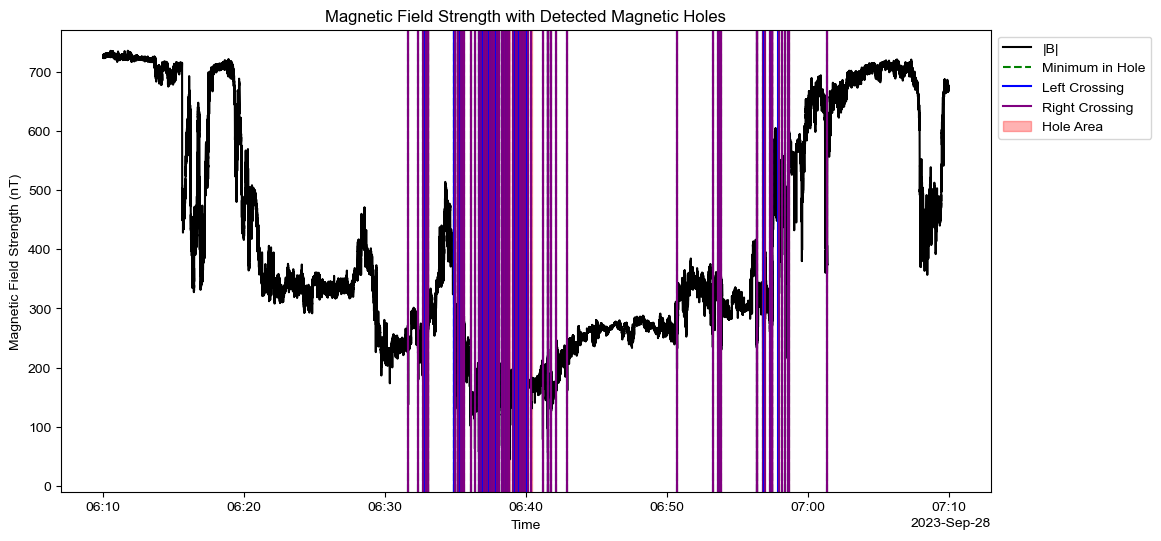

Generating iZotope marker file...
Saving iZotope marker file output
Running setup_output_directory from iZotope_marker_file_output:
Entering setup_output_directory with base_save_dir: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
Encounter directory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes/E17
Creating encounter directory: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes/E17
Final subdirectory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
Exiting setup_output_directory, returning: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
File path: /U

Button(description='Show Directory', style=ButtonStyle())

Exporting audio files...
Requested time range: ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000']
Running setup_output_directory from audify without plot
Fetching MAG data (standard res) for ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] using Plotbot and global instance.
[MH_DM_DEBUG] >>> Calling plotbot_get_data with trange=['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] and passing the global_plotbot_mag_rtn instance (id=13059265872).
🛰️ mag_RTN - acquiring all variables
Processing Data Type: mag_RTN...
[CUBBY] 
=== Retrieving mag_rtn from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/get_data.py:258
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn with type <class 'plotbot.data_classes.psp_mag_classes.mag_rtn_class'>
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(1059369,), range=2023-09-28T06:09:52.002628 to 2023-09-28T07:10:07.997686
[CUBBY] GRAB OUTPUT - raw_data keys=['all', 'br', 'bt', 'bn', 'bmag'

Button(description='Show Directory', style=ButtonStyle())

Button(description='Open |B|', style=ButtonStyle())

Button(description='Open Br', style=ButtonStyle())

Button(description='Open Bt', style=ButtonStyle())

Button(description='Open Bn', style=ButtonStyle())

Run settings and summary saved to: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes/run_settings_and_summary.json
Magnetic hole detection and output generation complete for trange: ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000']

✅ Analysis complete. 106 holes confirmed.

--- Magnetic Hole Detection Summary (from returned counter) ---
potential: 158
small_threshold_cross: 42
asymmetric_initial: 35
complex_holes_flagged: 35
shallow: 52
confirmed: 106
---------------------------------------------------------------
All outputs (plots, markers, settings JSON) saved in the run-specific subdirectory.


In [5]:
trange_E9_1 = ['2021-08-10/00:00:00', '2021-08-10/02:00:00']
trange_E10_1 = ['2021-11-22/00:30:00', '2021-11-22/03:30:00']
trange_E11_1 = ['2022-02-25/12:00:00', '2022-02-25/13:00:00']
trange_E15_2 = ['2023-03-17/20:30:00', '2023-03-17/21:45:00']
trange_E17_1 = ['2023-09-28/06:32:00', '2023-09-28/06:45:00']
trange_E15_1 = ['2023-03-16/02:15:00', '2023-03-16/02:30:00']

TIME_RANGE_TO_ANALYZE = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] 
# Or any other trange you want to test

print(f"Starting analysis for trange: {trange_E9_1}...")
print(f"Outputs will be saved within base directory: {BASE_SAVE_DIRECTORY}")

# The main call to the refactored orchestrator function
# It now handles sub_save_dir creation, detection, and all standard outputs internally.
analysis_results = detect_magnetic_holes_and_generate_outputs(
    TIME_RANGE_TO_ANALYZE,
    BASE_SAVE_DIRECTORY, # Pass the top-level save directory
    mh_run_settings      # Pass the configured settings object
)

# The function returns the primary scientific results for optional inspection
if analysis_results:
    magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag, magnetic_hole_details, returned_hole_counter = analysis_results
    print(f"\n✅ Analysis complete. {returned_hole_counter.get('confirmed', 0)} holes confirmed.")
    # You can still do a quick print of the counter here
    print("\n--- Magnetic Hole Detection Summary (from returned counter) ---")
    for key, value in returned_hole_counter.items():
        print(f"{key}: {value}")
    print("---------------------------------------------------------------")
    print(f"All outputs (plots, markers, settings JSON) saved in the run-specific subdirectory.")
else:
    print("Analysis aborted or returned no results (check logs for errors).")


In [ ]:
# --- Plotbot Imports and Configuration ---
try:
    from plotbot import print_manager as pm
    # Set these to True if you want to see detailed logs from Plotbot's core & magnetic_hole_finder_core
    pm.show_error = True
    pm.show_warnings = True
    pm.show_status = True # To see status messages from the core function
    pm.show_debug = True  # To see [MH_DM_DEBUG] and other debugs from core
    pm.show_datacubby = False # Or True if debugging DataCubby
    pm.show_processing = False # Or True for Plotbot processing steps
    print("Successfully imported and configured Plotbot's print_manager.")
except ImportError:
    print("Could not import Plotbot's print_manager...")
    pm = None

# --- Local Application Imports (magnetic_hole_finder) ---
# We only need the main orchestrator function and the settings class now from the core
from magnetic_hole_finder.magnetic_hole_finder_core import HoleFinderSettings, detect_magnetic_holes_and_generate_outputs
from collections import Counter # For understanding the returned counter object if needed

# Other imports that might be used *only* in the notebook for ad-hoc stuff (if any)
# Most of these (numpy, pandas, datetime, json, os) are now primarily used within the .py files
import numpy as np 
import pandas as pd
import json
import os
from datetime import datetime 

# --- Warnings Handling Configuration ---
from warnings import simplefilter
import warnings
simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="IPython.core.pylabtools")

current_time_consolidated = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f'{current_time_consolidated} - 📚 All libraries imported and environment configured.')

initialized server_access
initialized global_tracker
initialized ploptions
initialized plot_manager
initialized mag_rtn_4sa class
initialized mag_rtn class
initialized mag_sc_4sa class
initialized mag_sc class
initialized epad class
initialized epad_hr class
initialized proton class
initialized proton_hr class
initialized data_cubby
initialized proton_fits class
initialized ham_class
🔉 initialized audifier

Importing libraries, this may take a moment. Hold tight... 

✅ Imported standard libraries and utilities.
✅ Imported numpy, pandas, and scipy libraries.
✅ Imported matplotlib libraries.
✅ Imported cdflib, BeautifulSoup, requests, dateutil, and datetime libraries.

🤖 Plotbot Initialized
✨ Showdahodo initialized
Positional Data Helper Initialized
📈📉 Multiplot Initialized
   Version: 2025_05_06_v2.23
Commit: fix: Vertical line at x=0 in degrees_from_perihelion mode (v2.23)

🤖 Plotbot Initialized
Successfully imported and configured Plotbot's print_manager.
2025-05-06 15:35:02.419 - ⏱️ 

In [ ]:
#Cell 2
# --- Hardcode the base directory for algorithm outputs ---
import os # Ensure os is imported if not already
save_dir = os.path.abspath("MH_Scan_Output") # Path relative to project root
os.makedirs(save_dir, exist_ok=True)       # Create it if it doesn't exist
print(f'🛟 Algorithm output directory (save_dir) set to: {save_dir}')

🛟 Algorithm output directory (save_dir) set to: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output


In [ ]:
#Cell 3
from magnetic_hole_finder.magnetic_hole_finder_core import detect_magnetic_holes, HoleFinderSettings
from collections import Counter # If you want to use the returned counter object directly

In [ ]:
#Cell 4
mh_settings = HoleFinderSettings()


# --- Configure Core Algorithm Settings ---
mh_settings.INSTRUMENT_SAMPLING_RATE = 292.9  # Default is already this, but shown for example
mh_settings.use_calculated_sampling_rate = True # Default is True
mh_settings.depth_percentage_threshold = 0.25
mh_settings.smoothing_window_seconds = 8.0
mh_settings.derivative_window_seconds = 0.2
mh_settings.min_max_finding_smooth_window = 0.3
mh_settings.mean_threshold = 0.8
mh_settings.search_in_progress_output = True  # For verbose logging from the algorithm
mh_settings.additional_seconds_for_min_search = 0.2
mh_settings.asymetric_peak_threshold = 0.25
mh_settings.symmetrical_peak_scan_window_in_secs = 2.0
mh_settings.Bave_scan_seconds = 0.1
mh_settings.Bave_window_seconds = 20.0
mh_settings.wide_angle_threshold = 15.0
mh_settings.small_threshold_cross_flag_samples = 10
mh_settings.small_threshold_cross_adjustment_samples = 10

# Note: The HoleFinderSettings class already has defaults for these.
# You only need to set them if you want to change them from the defaults defined in the class.
# These settings (OUTPUT_PLOT, etc.) in HoleFinderSettings primarily affect
# what analyze_derivative_zero_crossings might do if it has plotting logic.
# Your main notebook plotting cell will handle the actual final plot generation.
mh_settings.OUTPUT_ZERO_CROSSING_PLOT = False 

# --- Configure Flag Handling / Breaking Conditions ---
mh_settings.break_for_shallow_hole = True
mh_settings.break_for_assymettry = False 
mh_settings.break_for_wide_angle = False
mh_settings.break_for_small_threshold_cross = False
mh_settings.break_for_complex_hole = False
mh_settings.threshold_for_derivative_0_crossings_flag = 1000 # If a hole has more 0-crossings, it's flagged
mh_settings.break_for_derivative_crossings = False

# --- Settings for file output and separate plotting routines (outside detect_magnetic_holes) ---
# These were in your notebook but are NOT part of the HoleFinderSettings class
# because they are generally used AFTER detect_magnetic_holes returns its results.
# You'll keep these as regular variables in your notebook's "command center" section.

# Example:
OUTPUT_FINAL_PLOT = True  # Controls your notebook's final plot_mag_data_with_holes_and_minimum call
SAVE_FINAL_PLOT = True    # Controls if that plot is saved

IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN = True
MARKER_FILE_VERSION = 3
IZOTOPE_MARKER_FILE_OUTPUT = False # Or True, as needed

EXPORT_AUDIO_FILES = True
AUDIO_SAMPLING_RATE = 22000

Marker_Files_With_Annotated_Markers = False
Marker_Files_With_Hole_Numbers = False

# Note on SEARCH_IN_PROGRESS_OUTPUT: 
# mh_settings.search_in_progress_output = True # This controls prints WITHIN detect_magnetic_holes
# The one below was a standalone variable, likely for other parts of your notebook.
# If it's only for detect_magnetic_holes, then the mh_settings one is sufficient.
# SEARCH_IN_PROGRESS_OUTPUT_NOTEBOOK = True # If needed for other notebook cells

In [ ]:
#Cell 5
trange = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] 

# Automatically generate the specific subdirectory for this run
# `setup_output_directory` is from your data_management.py or similar
sub_save_dir = setup_output_directory(trange, save_dir) 
print(f"✅ Output for this run will be saved in: {sub_save_dir}")

# Call the refactored detection function
magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag, magnetic_hole_details, returned_hole_counter = detect_magnetic_holes(
    trange, 
    mh_settings 
)

In [ ]:
# Cell 6
# --- Plotting ---
if NOTEBOOK_OUTPUT_PLOT and times_clipped is not None and bmag is not None:
    plot_mag_data_with_holes_and_minimum(
        times_clipped, 
        bmag, 
        magnetic_holes, 
        hole_minima, 
        hole_maxima_pairs, 
        mh_settings.plot_hole_minimum, # Use setting from the class if it controls this aspect
        mh_settings.plot_smooth_threshold_crossing, # Use setting
        trange,
        sub_save_dir, # Save plot to the generated subdirectory
        NOTEBOOK_SAVE_PLOT 
    )

# --- Save Settings to JSON in the sub_save_dir ---
if sub_save_dir: # Ensure sub_save_dir was created
    settings_file_path = os.path.join(sub_save_dir, 'magnetic_hole_detection_settings.json')
    # Create a dictionary from the settings object for saving
    settings_to_save = mh_settings.__dict__ 
    # You might want to add other relevant info, like the trange used for this run
    settings_to_save['trange_run'] = trange
    try:
        with open(settings_file_path, 'w') as f:
            json.dump(settings_to_save, f, indent=4)
        print(f"Settings saved to: {settings_file_path}")
    except Exception as e:
        print(f"Error saving settings to JSON: {e}")


# --- Marker File Output ---
if NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT and sub_save_dir: # check sub_save_dir
    # Assume output_magnetic_holes takes sub_save_dir
    # Also, ensure INSTRUMENT_SAMPLING_RATE is correctly passed; 
    # it might come from mh_settings or the calculated one if that's preferred for output.
    # For now, let's use the one from settings for simplicity, but this might need thought.
    # If your core function now calculates and uses `current_instrument_sampling_rate`,
    # that calculated rate should ideally be returned or accessible for these output functions.
    # Let's assume `mh_settings.INSTRUMENT_SAMPLING_RATE` is okay for now.
    # Or, if `detect_magnetic_holes` returns the actually used sampling rate, use that.
    
    # If your core function now returns the *actually used* sampling rate:
    # (assuming you modify detect_magnetic_holes to return it, e.g., as an additional item)
    # actual_sampling_rate_used = ... # get this from detect_magnetic_holes results
    
    # For now, using the one from settings as a placeholder:
    sampling_rate_for_output = mh_settings.INSTRUMENT_SAMPLING_RATE 
    if mh_settings.use_calculated_sampling_rate and returned_hole_counter.get('calculated_sr'): # A bit of a hack, ideally get SR directly
            # This part is tricky without knowing if the *actual* calculated SR is returned
            # For robustness, it's best if detect_magnetic_holes returns the SR it used.
            # Let's assume for now the notebook has access to the correct SR to pass.
            pass


    output_magnetic_holes(
        magnetic_holes,
        hole_maxima_pairs, # Assuming this contains the right indices
        times_clipped,     # For timestamps
        bmag,              # Not directly used by iZotope format, but might be for context
        False, # IZOTOPE_MARKER_FILE_OUTPUT (general)
        NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT, # Specific max/min format
        trange,
        NOTEBOOK_MARKER_VERSION,
        mh_settings.search_in_progress_output, # or a notebook specific var
        sub_save_dir, # Save to the generated subdirectory
        sampling_rate_for_output, # Pass the relevant sampling rate
        False, # Marker_Files_With_Annotated_Markers
        False, # Marker_Files_With_Hole_Numbers
        magnetic_hole_details
    )

# --- Audio Export (if applicable) ---
# if EXPORT_AUDIO_FILES and sub_save_dir:
#     audify_high_res_mag_data_without_plot(trange[0], trange[1], sub_save_dir, AUDIO_SAMPLING_RATE, sub_save_dir)


# --- Summary Print ---
print("\n--- Magnetic Hole Detection Summary (from returned counter) ---")
if returned_hole_counter:
    for key, value in returned_hole_counter.items():
        print(f"{key}: {value}")
print("-------------------------------------")

##---------------------That's it!! 🐴 ---------------------##

In [6]:
# --- Plotbot Imports and Configuration ---
try:
    from plotbot import print_manager as pm
    # Set these to True if you want to see detailed logs from Plotbot's core & magnetic_hole_finder_core
    pm.show_error = True
    pm.show_warnings = True
    pm.show_status = True # To see status messages from the core function
    pm.show_debug = True  # To see [MH_DM_DEBUG] and other debugs from core
    pm.show_datacubby = False # Or True if debugging DataCubby
    pm.show_processing = False # Or True for Plotbot processing steps
    print("Successfully imported and configured Plotbot's print_manager.")
except ImportError:
    print("Could not import Plotbot's print_manager...")
    pm = None

# --- Local Application Imports (magnetic_hole_finder) ---
# We only need the main orchestrator function and the settings class now from the core
from magnetic_hole_finder.magnetic_hole_finder_core import HoleFinderSettings, detect_magnetic_holes_and_generate_outputs
from collections import Counter # For understanding the returned counter object if needed

# Other imports that might be used *only* in the notebook for ad-hoc stuff (if any)
# Most of these (numpy, pandas, datetime, json, os) are now primarily used within the .py files
import numpy as np 
import pandas as pd
import json
import os
from datetime import datetime 

# --- Warnings Handling Configuration ---
from warnings import simplefilter
import warnings
simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="IPython.core.pylabtools")

current_time_consolidated = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f'{current_time_consolidated} - 📚 All libraries imported and environment configured.')

Successfully imported and configured Plotbot's print_manager.
2025-05-06 15:35:08 - 📚 All libraries imported and environment configured.


In [7]:
#Cell 2
# --- Hardcode the base directory for algorithm outputs ---
import os # Ensure os is imported if not already
save_dir = os.path.abspath("MH_Scan_Output") # Path relative to project root
os.makedirs(save_dir, exist_ok=True)       # Create it if it doesn't exist
print(f'🛟 Algorithm output directory (save_dir) set to: {save_dir}')

🛟 Algorithm output directory (save_dir) set to: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output


In [8]:
#Cell 3
from magnetic_hole_finder.magnetic_hole_finder_core import detect_magnetic_holes, HoleFinderSettings
from collections import Counter # If you want to use the returned counter object directly

ImportError: cannot import name 'detect_magnetic_holes' from 'magnetic_hole_finder.magnetic_hole_finder_core' (/Users/robertalexander/GitHub/Plotbot/magnetic_hole_finder/magnetic_hole_finder_core.py)

In [ ]:
#Cell 4
mh_settings = HoleFinderSettings()


# --- Configure Core Algorithm Settings ---
mh_settings.INSTRUMENT_SAMPLING_RATE = 292.9  # Default is already this, but shown for example
mh_settings.use_calculated_sampling_rate = True # Default is True
mh_settings.depth_percentage_threshold = 0.25
mh_settings.smoothing_window_seconds = 8.0
mh_settings.derivative_window_seconds = 0.2
mh_settings.min_max_finding_smooth_window = 0.3
mh_settings.mean_threshold = 0.8
mh_settings.search_in_progress_output = True  # For verbose logging from the algorithm
mh_settings.additional_seconds_for_min_search = 0.2
mh_settings.asymetric_peak_threshold = 0.25
mh_settings.symmetrical_peak_scan_window_in_secs = 2.0
mh_settings.Bave_scan_seconds = 0.1
mh_settings.Bave_window_seconds = 20.0
mh_settings.wide_angle_threshold = 15.0
mh_settings.small_threshold_cross_flag_samples = 10
mh_settings.small_threshold_cross_adjustment_samples = 10

# Note: The HoleFinderSettings class already has defaults for these.
# You only need to set them if you want to change them from the defaults defined in the class.
# These settings (OUTPUT_PLOT, etc.) in HoleFinderSettings primarily affect
# what analyze_derivative_zero_crossings might do if it has plotting logic.
# Your main notebook plotting cell will handle the actual final plot generation.
mh_settings.OUTPUT_ZERO_CROSSING_PLOT = False 

# --- Configure Flag Handling / Breaking Conditions ---
mh_settings.break_for_shallow_hole = True
mh_settings.break_for_assymettry = False 
mh_settings.break_for_wide_angle = False
mh_settings.break_for_small_threshold_cross = False
mh_settings.break_for_complex_hole = False
mh_settings.threshold_for_derivative_0_crossings_flag = 1000 # If a hole has more 0-crossings, it's flagged
mh_settings.break_for_derivative_crossings = False

# --- Settings for file output and separate plotting routines (outside detect_magnetic_holes) ---
# These were in your notebook but are NOT part of the HoleFinderSettings class
# because they are generally used AFTER detect_magnetic_holes returns its results.
# You'll keep these as regular variables in your notebook's "command center" section.

# Example:
OUTPUT_FINAL_PLOT = True  # Controls your notebook's final plot_mag_data_with_holes_and_minimum call
SAVE_FINAL_PLOT = True    # Controls if that plot is saved

IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN = True
MARKER_FILE_VERSION = 3
IZOTOPE_MARKER_FILE_OUTPUT = False # Or True, as needed

EXPORT_AUDIO_FILES = True
AUDIO_SAMPLING_RATE = 22000

Marker_Files_With_Annotated_Markers = False
Marker_Files_With_Hole_Numbers = False

# Note on SEARCH_IN_PROGRESS_OUTPUT: 
# mh_settings.search_in_progress_output = True # This controls prints WITHIN detect_magnetic_holes
# The one below was a standalone variable, likely for other parts of your notebook.
# If it's only for detect_magnetic_holes, then the mh_settings one is sufficient.
# SEARCH_IN_PROGRESS_OUTPUT_NOTEBOOK = True # If needed for other notebook cells

In [ ]:
#Cell 5
trange = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] 

# Automatically generate the specific subdirectory for this run
# `setup_output_directory` is from your data_management.py or similar
sub_save_dir = setup_output_directory(trange, save_dir) 
print(f"✅ Output for this run will be saved in: {sub_save_dir}")

# Call the refactored detection function
magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag, magnetic_hole_details, returned_hole_counter = detect_magnetic_holes(
    trange, 
    mh_settings 
)

In [ ]:
# Cell 6
# --- Plotting ---
if NOTEBOOK_OUTPUT_PLOT and times_clipped is not None and bmag is not None:
    plot_mag_data_with_holes_and_minimum(
        times_clipped, 
        bmag, 
        magnetic_holes, 
        hole_minima, 
        hole_maxima_pairs, 
        mh_settings.plot_hole_minimum, # Use setting from the class if it controls this aspect
        mh_settings.plot_smooth_threshold_crossing, # Use setting
        trange,
        sub_save_dir, # Save plot to the generated subdirectory
        NOTEBOOK_SAVE_PLOT 
    )

# --- Save Settings to JSON in the sub_save_dir ---
if sub_save_dir: # Ensure sub_save_dir was created
    settings_file_path = os.path.join(sub_save_dir, 'magnetic_hole_detection_settings.json')
    # Create a dictionary from the settings object for saving
    settings_to_save = mh_settings.__dict__ 
    # You might want to add other relevant info, like the trange used for this run
    settings_to_save['trange_run'] = trange
    try:
        with open(settings_file_path, 'w') as f:
            json.dump(settings_to_save, f, indent=4)
        print(f"Settings saved to: {settings_file_path}")
    except Exception as e:
        print(f"Error saving settings to JSON: {e}")


# --- Marker File Output ---
if NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT and sub_save_dir: # check sub_save_dir
    # Assume output_magnetic_holes takes sub_save_dir
    # Also, ensure INSTRUMENT_SAMPLING_RATE is correctly passed; 
    # it might come from mh_settings or the calculated one if that's preferred for output.
    # For now, let's use the one from settings for simplicity, but this might need thought.
    # If your core function now calculates and uses `current_instrument_sampling_rate`,
    # that calculated rate should ideally be returned or accessible for these output functions.
    # Let's assume `mh_settings.INSTRUMENT_SAMPLING_RATE` is okay for now.
    # Or, if `detect_magnetic_holes` returns the actually used sampling rate, use that.
    
    # If your core function now returns the *actually used* sampling rate:
    # (assuming you modify detect_magnetic_holes to return it, e.g., as an additional item)
    # actual_sampling_rate_used = ... # get this from detect_magnetic_holes results
    
    # For now, using the one from settings as a placeholder:
    sampling_rate_for_output = mh_settings.INSTRUMENT_SAMPLING_RATE 
    if mh_settings.use_calculated_sampling_rate and returned_hole_counter.get('calculated_sr'): # A bit of a hack, ideally get SR directly
            # This part is tricky without knowing if the *actual* calculated SR is returned
            # For robustness, it's best if detect_magnetic_holes returns the SR it used.
            # Let's assume for now the notebook has access to the correct SR to pass.
            pass


    output_magnetic_holes(
        magnetic_holes,
        hole_maxima_pairs, # Assuming this contains the right indices
        times_clipped,     # For timestamps
        bmag,              # Not directly used by iZotope format, but might be for context
        False, # IZOTOPE_MARKER_FILE_OUTPUT (general)
        NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT, # Specific max/min format
        trange,
        NOTEBOOK_MARKER_VERSION,
        mh_settings.search_in_progress_output, # or a notebook specific var
        sub_save_dir, # Save to the generated subdirectory
        sampling_rate_for_output, # Pass the relevant sampling rate
        False, # Marker_Files_With_Annotated_Markers
        False, # Marker_Files_With_Hole_Numbers
        magnetic_hole_details
    )

# --- Audio Export (if applicable) ---
# if EXPORT_AUDIO_FILES and sub_save_dir:
#     audify_high_res_mag_data_without_plot(trange[0], trange[1], sub_save_dir, AUDIO_SAMPLING_RATE, sub_save_dir)


# --- Summary Print ---
print("\n--- Magnetic Hole Detection Summary (from returned counter) ---")
if returned_hole_counter:
    for key, value in returned_hole_counter.items():
        print(f"{key}: {value}")
print("-------------------------------------")

In [ ]:
#Cell 4
mh_settings = HoleFinderSettings()


# --- Configure Core Algorithm Settings ---
mh_settings.INSTRUMENT_SAMPLING_RATE = 292.9  # Default is already this, but shown for example
mh_settings.use_calculated_sampling_rate = True # Default is True
mh_settings.depth_percentage_threshold = 0.25
mh_settings.smoothing_window_seconds = 8.0
mh_settings.derivative_window_seconds = 0.2
mh_settings.min_max_finding_smooth_window = 0.3
mh_settings.mean_threshold = 0.8
mh_settings.search_in_progress_output = True  # For verbose logging from the algorithm
mh_settings.additional_seconds_for_min_search = 0.2
mh_settings.asymetric_peak_threshold = 0.25
mh_settings.symmetrical_peak_scan_window_in_secs = 2.0
mh_settings.Bave_scan_seconds = 0.1
mh_settings.Bave_window_seconds = 20.0
mh_settings.wide_angle_threshold = 15.0
mh_settings.small_threshold_cross_flag_samples = 10
mh_settings.small_threshold_cross_adjustment_samples = 10

# Note: The HoleFinderSettings class already has defaults for these.
# You only need to set them if you want to change them from the defaults defined in the class.
# These settings (OUTPUT_PLOT, etc.) in HoleFinderSettings primarily affect
# what analyze_derivative_zero_crossings might do if it has plotting logic.
# Your main notebook plotting cell will handle the actual final plot generation.
mh_settings.OUTPUT_ZERO_CROSSING_PLOT = False 

# --- Configure Flag Handling / Breaking Conditions ---
mh_settings.break_for_shallow_hole = True
mh_settings.break_for_assymettry = False 
mh_settings.break_for_wide_angle = False
mh_settings.break_for_small_threshold_cross = False
mh_settings.break_for_complex_hole = False
mh_settings.threshold_for_derivative_0_crossings_flag = 1000 # If a hole has more 0-crossings, it's flagged
mh_settings.break_for_derivative_crossings = False

# --- Settings for file output and separate plotting routines (outside detect_magnetic_holes) ---
# These were in your notebook but are NOT part of the HoleFinderSettings class
# because they are generally used AFTER detect_magnetic_holes returns its results.
# You'll keep these as regular variables in your notebook's "command center" section.

# Example:
OUTPUT_FINAL_PLOT = True  # Controls your notebook's final plot_mag_data_with_holes_and_minimum call
SAVE_FINAL_PLOT = True    # Controls if that plot is saved

IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN = True
MARKER_FILE_VERSION = 3
IZOTOPE_MARKER_FILE_OUTPUT = False # Or True, as needed

EXPORT_AUDIO_FILES = True
AUDIO_SAMPLING_RATE = 22000

Marker_Files_With_Annotated_Markers = False
Marker_Files_With_Hole_Numbers = False

# Note on SEARCH_IN_PROGRESS_OUTPUT: 
# mh_settings.search_in_progress_output = True # This controls prints WITHIN detect_magnetic_holes
# The one below was a standalone variable, likely for other parts of your notebook.
# If it's only for detect_magnetic_holes, then the mh_settings one is sufficient.
# SEARCH_IN_PROGRESS_OUTPUT_NOTEBOOK = True # If needed for other notebook cells

In [ ]:
#Cell 5
trange = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] 

# Automatically generate the specific subdirectory for this run
# `setup_output_directory` is from your data_management.py or similar
sub_save_dir = setup_output_directory(trange, save_dir) 
print(f"✅ Output for this run will be saved in: {sub_save_dir}")

# Call the refactored detection function
magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag, magnetic_hole_details, returned_hole_counter = detect_magnetic_holes(
    trange, 
    mh_settings 
)

In [ ]:
# Cell 6
# --- Plotting ---
if NOTEBOOK_OUTPUT_PLOT and times_clipped is not None and bmag is not None:
    plot_mag_data_with_holes_and_minimum(
        times_clipped, 
        bmag, 
        magnetic_holes, 
        hole_minima, 
        hole_maxima_pairs, 
        mh_settings.plot_hole_minimum, # Use setting from the class if it controls this aspect
        mh_settings.plot_smooth_threshold_crossing, # Use setting
        trange,
        sub_save_dir, # Save plot to the generated subdirectory
        NOTEBOOK_SAVE_PLOT 
    )

# --- Save Settings to JSON in the sub_save_dir ---
if sub_save_dir: # Ensure sub_save_dir was created
    settings_file_path = os.path.join(sub_save_dir, 'magnetic_hole_detection_settings.json')
    # Create a dictionary from the settings object for saving
    settings_to_save = mh_settings.__dict__ 
    # You might want to add other relevant info, like the trange used for this run
    settings_to_save['trange_run'] = trange
    try:
        with open(settings_file_path, 'w') as f:
            json.dump(settings_to_save, f, indent=4)
        print(f"Settings saved to: {settings_file_path}")
    except Exception as e:
        print(f"Error saving settings to JSON: {e}")


# --- Marker File Output ---
if NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT and sub_save_dir: # check sub_save_dir
    # Assume output_magnetic_holes takes sub_save_dir
    # Also, ensure INSTRUMENT_SAMPLING_RATE is correctly passed; 
    # it might come from mh_settings or the calculated one if that's preferred for output.
    # For now, let's use the one from settings for simplicity, but this might need thought.
    # If your core function now calculates and uses `current_instrument_sampling_rate`,
    # that calculated rate should ideally be returned or accessible for these output functions.
    # Let's assume `mh_settings.INSTRUMENT_SAMPLING_RATE` is okay for now.
    # Or, if `detect_magnetic_holes` returns the actually used sampling rate, use that.
    
    # If your core function now returns the *actually used* sampling rate:
    # (assuming you modify detect_magnetic_holes to return it, e.g., as an additional item)
    # actual_sampling_rate_used = ... # get this from detect_magnetic_holes results
    
    # For now, using the one from settings as a placeholder:
    sampling_rate_for_output = mh_settings.INSTRUMENT_SAMPLING_RATE 
    if mh_settings.use_calculated_sampling_rate and returned_hole_counter.get('calculated_sr'): # A bit of a hack, ideally get SR directly
            # This part is tricky without knowing if the *actual* calculated SR is returned
            # For robustness, it's best if detect_magnetic_holes returns the SR it used.
            # Let's assume for now the notebook has access to the correct SR to pass.
            pass


    output_magnetic_holes(
        magnetic_holes,
        hole_maxima_pairs, # Assuming this contains the right indices
        times_clipped,     # For timestamps
        bmag,              # Not directly used by iZotope format, but might be for context
        False, # IZOTOPE_MARKER_FILE_OUTPUT (general)
        NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT, # Specific max/min format
        trange,
        NOTEBOOK_MARKER_VERSION,
        mh_settings.search_in_progress_output, # or a notebook specific var
        sub_save_dir, # Save to the generated subdirectory
        sampling_rate_for_output, # Pass the relevant sampling rate
        False, # Marker_Files_With_Annotated_Markers
        False, # Marker_Files_With_Hole_Numbers
        magnetic_hole_details
    )

# --- Audio Export (if applicable) ---
# if EXPORT_AUDIO_FILES and sub_save_dir:
#     audify_high_res_mag_data_without_plot(trange[0], trange[1], sub_save_dir, AUDIO_SAMPLING_RATE, sub_save_dir)


# --- Summary Print ---
print("\n--- Magnetic Hole Detection Summary (from returned counter) ---")
if returned_hole_counter:
    for key, value in returned_hole_counter.items():
        print(f"{key}: {value}")
print("-------------------------------------")

In [2]:
#Cell 2
# --- Hardcode the base directory for algorithm outputs ---
import os # Ensure os is imported if not already
save_dir = os.path.abspath("MH_Scan_Output") # Path relative to project root
os.makedirs(save_dir, exist_ok=True)       # Create it if it doesn't exist
print(f'🛟 Algorithm output directory (save_dir) set to: {save_dir}')

🛟 Algorithm output directory (save_dir) set to: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output


In [3]:
#Cell 3
from magnetic_hole_finder.magnetic_hole_finder_core import detect_magnetic_holes, HoleFinderSettings
from collections import Counter # If you want to use the returned counter object directly

In [4]:
#Cell 4
mh_settings = HoleFinderSettings()


# --- Configure Core Algorithm Settings ---
mh_settings.INSTRUMENT_SAMPLING_RATE = 292.9  # Default is already this, but shown for example
mh_settings.use_calculated_sampling_rate = True # Default is True
mh_settings.depth_percentage_threshold = 0.25
mh_settings.smoothing_window_seconds = 8.0
mh_settings.derivative_window_seconds = 0.2
mh_settings.min_max_finding_smooth_window = 0.3
mh_settings.mean_threshold = 0.8
mh_settings.search_in_progress_output = True  # For verbose logging from the algorithm
mh_settings.additional_seconds_for_min_search = 0.2
mh_settings.asymetric_peak_threshold = 0.25
mh_settings.symmetrical_peak_scan_window_in_secs = 2.0
mh_settings.Bave_scan_seconds = 0.1
mh_settings.Bave_window_seconds = 20.0
mh_settings.wide_angle_threshold = 15.0
mh_settings.small_threshold_cross_flag_samples = 10
mh_settings.small_threshold_cross_adjustment_samples = 10

# Note: The HoleFinderSettings class already has defaults for these.
# You only need to set them if you want to change them from the defaults defined in the class.
# These settings (OUTPUT_PLOT, etc.) in HoleFinderSettings primarily affect
# what analyze_derivative_zero_crossings might do if it has plotting logic.
# Your main notebook plotting cell will handle the actual final plot generation.
mh_settings.OUTPUT_ZERO_CROSSING_PLOT = False 

# --- Configure Flag Handling / Breaking Conditions ---
mh_settings.break_for_shallow_hole = True
mh_settings.break_for_assymettry = False 
mh_settings.break_for_wide_angle = False
mh_settings.break_for_small_threshold_cross = False
mh_settings.break_for_complex_hole = False
mh_settings.threshold_for_derivative_0_crossings_flag = 1000 # If a hole has more 0-crossings, it's flagged
mh_settings.break_for_derivative_crossings = False

# --- Settings for file output and separate plotting routines (outside detect_magnetic_holes) ---
# These were in your notebook but are NOT part of the HoleFinderSettings class
# because they are generally used AFTER detect_magnetic_holes returns its results.
# You'll keep these as regular variables in your notebook's "command center" section.

# Example:
OUTPUT_FINAL_PLOT = True  # Controls your notebook's final plot_mag_data_with_holes_and_minimum call
SAVE_FINAL_PLOT = True    # Controls if that plot is saved

IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN = True
MARKER_FILE_VERSION = 3
IZOTOPE_MARKER_FILE_OUTPUT = False # Or True, as needed

EXPORT_AUDIO_FILES = True
AUDIO_SAMPLING_RATE = 22000

Marker_Files_With_Annotated_Markers = False
Marker_Files_With_Hole_Numbers = False

# Note on SEARCH_IN_PROGRESS_OUTPUT: 
# mh_settings.search_in_progress_output = True # This controls prints WITHIN detect_magnetic_holes
# The one below was a standalone variable, likely for other parts of your notebook.
# If it's only for detect_magnetic_holes, then the mh_settings one is sufficient.
# SEARCH_IN_PROGRESS_OUTPUT_NOTEBOOK = True # If needed for other notebook cells

In [ ]:
#Cell 5
trange = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] 

# Automatically generate the specific subdirectory for this run
# `setup_output_directory` is from your data_management.py or similar
sub_save_dir = setup_output_directory(trange, save_dir) 
print(f"✅ Output for this run will be saved in: {sub_save_dir}")

# Call the refactored detection function
magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag, magnetic_hole_details, returned_hole_counter = detect_magnetic_holes(
    trange, 
    mh_settings 
)

In [ ]:
# Cell 6
# --- Plotting ---
if NOTEBOOK_OUTPUT_PLOT and times_clipped is not None and bmag is not None:
    plot_mag_data_with_holes_and_minimum(
        times_clipped, 
        bmag, 
        magnetic_holes, 
        hole_minima, 
        hole_maxima_pairs, 
        mh_settings.plot_hole_minimum, # Use setting from the class if it controls this aspect
        mh_settings.plot_smooth_threshold_crossing, # Use setting
        trange,
        sub_save_dir, # Save plot to the generated subdirectory
        NOTEBOOK_SAVE_PLOT 
    )

# --- Save Settings to JSON in the sub_save_dir ---
if sub_save_dir: # Ensure sub_save_dir was created
    settings_file_path = os.path.join(sub_save_dir, 'magnetic_hole_detection_settings.json')
    # Create a dictionary from the settings object for saving
    settings_to_save = mh_settings.__dict__ 
    # You might want to add other relevant info, like the trange used for this run
    settings_to_save['trange_run'] = trange
    try:
        with open(settings_file_path, 'w') as f:
            json.dump(settings_to_save, f, indent=4)
        print(f"Settings saved to: {settings_file_path}")
    except Exception as e:
        print(f"Error saving settings to JSON: {e}")


# --- Marker File Output ---
if NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT and sub_save_dir: # check sub_save_dir
    # Assume output_magnetic_holes takes sub_save_dir
    # Also, ensure INSTRUMENT_SAMPLING_RATE is correctly passed; 
    # it might come from mh_settings or the calculated one if that's preferred for output.
    # For now, let's use the one from settings for simplicity, but this might need thought.
    # If your core function now calculates and uses `current_instrument_sampling_rate`,
    # that calculated rate should ideally be returned or accessible for these output functions.
    # Let's assume `mh_settings.INSTRUMENT_SAMPLING_RATE` is okay for now.
    # Or, if `detect_magnetic_holes` returns the actually used sampling rate, use that.
    
    # If your core function now returns the *actually used* sampling rate:
    # (assuming you modify detect_magnetic_holes to return it, e.g., as an additional item)
    # actual_sampling_rate_used = ... # get this from detect_magnetic_holes results
    
    # For now, using the one from settings as a placeholder:
    sampling_rate_for_output = mh_settings.INSTRUMENT_SAMPLING_RATE 
    if mh_settings.use_calculated_sampling_rate and returned_hole_counter.get('calculated_sr'): # A bit of a hack, ideally get SR directly
            # This part is tricky without knowing if the *actual* calculated SR is returned
            # For robustness, it's best if detect_magnetic_holes returns the SR it used.
            # Let's assume for now the notebook has access to the correct SR to pass.
            pass


    output_magnetic_holes(
        magnetic_holes,
        hole_maxima_pairs, # Assuming this contains the right indices
        times_clipped,     # For timestamps
        bmag,              # Not directly used by iZotope format, but might be for context
        False, # IZOTOPE_MARKER_FILE_OUTPUT (general)
        NOTEBOOK_IZOTOPE_MAX_MIN_OUTPUT, # Specific max/min format
        trange,
        NOTEBOOK_MARKER_VERSION,
        mh_settings.search_in_progress_output, # or a notebook specific var
        sub_save_dir, # Save to the generated subdirectory
        sampling_rate_for_output, # Pass the relevant sampling rate
        False, # Marker_Files_With_Annotated_Markers
        False, # Marker_Files_With_Hole_Numbers
        magnetic_hole_details
    )

# --- Audio Export (if applicable) ---
# if EXPORT_AUDIO_FILES and sub_save_dir:
#     audify_high_res_mag_data_without_plot(trange[0], trange[1], sub_save_dir, AUDIO_SAMPLING_RATE, sub_save_dir)


# --- Summary Print ---
print("\n--- Magnetic Hole Detection Summary (from returned counter) ---")
if returned_hole_counter:
    for key, value in returned_hole_counter.items():
        print(f"{key}: {value}")
print("-------------------------------------")

In [5]:
😎 STOP, Hole Time!

SyntaxError: invalid character '😎' (U+1F60E) (305378575.py, line 1)

In [3]:
# # Magnetic_Hole_Finder.ipynb

# # --- Plotbot Imports (if needed directly in the notebook) ---
# try:
#     from plotbot import print_manager as plotbot_pm
#     # Configure plotbot_pm if you want to control its verbosity for calls made from this notebook
#     # plotbot_pm.show_error = True
#     # plotbot_pm.show_warning = True
#     # plotbot_pm.show_status = False 
#     # plotbot_pm.show_debug = False
#     # plotbot_pm.show_datacubby = False
#     print("Successfully imported Plotbot's print_manager.")
# except ImportError:
#     print("Could not import Plotbot's print_manager for direct notebook use.")
#     plotbot_pm = None # or a dummy if you call its methods directly in the notebook

# # --- Imports from your magnetic_hole_finder modules ---
# # Assuming Magnetic_Hole_Finder.ipynb is in the Plotbot project root,
# # and 'magnetic_hole_finder' is a subdirectory.

# # Option 1: Import specific functions/classes you need directly
# # This is often cleaner as it shows exactly what the notebook depends on.
# from magnetic_hole_finder.data_management import download_and_prepare_high_res_mag_data, setup_output_directory # etc.
# from magnetic_hole_finder.MH_format_output import output_magnetic_holes # etc.
# # ... import other specific items you use in this notebook ...

# # Option 2: Import modules and access their contents via module name (can be less cluttered if you use many things)
# # import magnetic_hole_finder.data_management as mh_data_management
# # import magnetic_hole_finder.plotting as mh_plotting
# # Now you would call functions like: mh_data_management.download_and_prepare_high_res_mag_data(...)

# # Option 3: If you *really* want to bring everything into the global namespace (like your from ... import *),
# # but this is generally discouraged for clarity. If you do, ensure no name clashes.
# # from magnetic_hole_finder.data_management import *
# # from magnetic_hole_finder.plotting import *
# # ... etc for all your modules ...


# # --- Standard Library Imports ---
# from collections import Counter
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.colors
# from matplotlib import ticker, cm
# from scipy.io import readsav, wavfile # wavfile is also in scipy.io.wavfile
# from scipy.io.wavfile import write as write_wav # Alias to avoid conflict if you also import a 'write'
# from scipy import interpolate
# import bisect
# import json
# import os
# import sys # Only if you were doing sys.path manipulations, otherwise not needed here
# import contextlib # If used
# import cdflib # If used
# from datetime import datetime, timedelta
# from tkinter import Tk, filedialog # For your directory selection GUI
# import pickle
# import time

# # --- PySPEDAS and PyTPlot ---
# # These might not be needed directly in THIS notebook if all SPEDAS calls
# # are encapsulated within your magnetic_hole_finder modules (like data_management.py was)
# # If your MH modules now use plotbot.get_data, direct pyspedas imports here might be less necessary.
# # import pyspedas
# # from pyspedas import time_string, time_double, tinterpol, tdpwrspc # if used directly
# # import pytplot
# # from pytplot import ( # Only import what you directly use in the notebook
# #     tplot, store_data, get_data as pytplot_get_data, tlimit, xlim, ylim, tplot_options, options,
# #     split_vec, cdf_to_tplot, divide, tplot_names, get_timespan, tplot_rename,
# #     time_datetime
# # )


# # --- IPython Widgets (if used directly in notebook) ---
# import ipywidgets as widgets
# from IPython.display import display

# # --- Warnings Handling ---
# from warnings import simplefilter
# import warnings

# simplefilter(action='ignore', category=DeprecationWarning)
# warnings.filterwarnings("ignore") # This is very broad, consider being more specific if possible
# warnings.filterwarnings("ignore", category=DeprecationWarning, module="IPython.core.pylabtools")

# # Global Variables (declare if essential, but try to pass as parameters)
# # global save_dir, trange, trange_start, trange_stop # Using 'global' like this is often a sign to refactor

# current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# print(f'{current_time} - 📚 Libraries imported and environment configured.')


In [4]:
# #Set The Global Save Directory
# #Running this code will trigger a pop-up menu that will ask you to specify a directory where you'd like to save your files.
# #If you don't see a pop-up check your dock for a bouncing white python page and click that.
# #Each time you change this directory you'll need to re-run the cells that generate plots before they'll recognize the new location.
# #If this directory is not specified the code will not run properly.

# # Set The Global Save Directory
# global save_dir
# last_dir_file = "last_selected_dir.txt"  # Path to save the last selected directory
# save_dir = set_save_directory(last_dir_file)

# show_directory_button(save_dir) # Display the button to show the directory

# current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# print(f'{current_time} - 🛟 Save Directory Set: {save_dir}')

# #👇 Your save directory is confirmed here and you can click the button to see it.

In [5]:
# # In your magnetic_hole_finder notebook (e.g., ⭐️ MH_Scan_V6.5_MAIN.ipynb)

# # Import Plotbot's print_manager
# try:
#     from plotbot import print_manager as plotbot_pm # Use an alias to be clear
#     # Set desired levels
#     plotbot_pm.show_error = True    # Default is usually True
#     plotbot_pm.show_warnings = True  # Default is usually True
#     plotbot_pm.show_status = False  # Example: turn off status messages
#     plotbot_pm.show_debug = False   # Example: turn off debug messages
#     plotbot_pm.show_datacubby = False # Example: turn off DataCubby messages
#     plotbot_pm.show_processing = False
#     # ... set other plotbot_pm flags as needed ...
#     print("Successfully configured Plotbot's print_manager.")
# except ImportError:
#     print("Could not import Plotbot's print_manager. MH specific prints will use fallback.")
#     # If Plotbot's print_manager can't be imported, the FallbackPrintManager
#     # inside data_management.py will be used for messages from that file,
#     # which prints ERROR, WARNING, STATUS by default.

# # Now, when your code in magnetic_hole_finder/data_management.py runs 
# # (e.g., when download_and_save_data is called), 
# # it will try to use the plotbot_print_manager instance that you've just configured.

# # ... rest of your notebook code for magnetic hole finding ...

## 1) Find Magnetic Holes Through an Automated Routine

## DOING SOMETHING EPIC


In [6]:
# from collections import Counter
# from magnetic_hole_finder.asymmetry_calc import *
# from magnetic_hole_finder.time_management import *
# from magnetic_hole_finder.data_management import *
# from magnetic_hole_finder.plotting import *
# from magnetic_hole_finder.data_audification import *
# from magnetic_hole_finder.zero_crossing_analysis import analyze_derivative_zero_crossings # Keeping your specific import
# from magnetic_hole_finder.MH_format_output import *
# from magnetic_hole_finder.hole_angle_calc import *

In [7]:
# Set print_manager (p.m.) verbosity flags for debugging and error reporting
pm.show_debug = True
pm.show_error = True
pm.show_warnings = True
pm.show_status = True

Entering setup_output_directory with base_save_dir: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output
Encounter directory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17
Creating encounter directory: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17
Final subdirectory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
Exiting setup_output_directory, returning: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
🙌🙌🙌Main script: sub_save_dir set to /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
Extended time range: 2023-09-28 06:09:52 to 2023-09-28 07:10:08
Fetching MAG data (standard res) for ['2023-09-28/06:09:52.000000', '2023-09-28/07:10:08.000000'] using Plotbot and global instance.
[MH_DM_DEBUG] >>> Calling plotbot_get_data with trange=['2023-09-28/06:09:52.000000', '2023

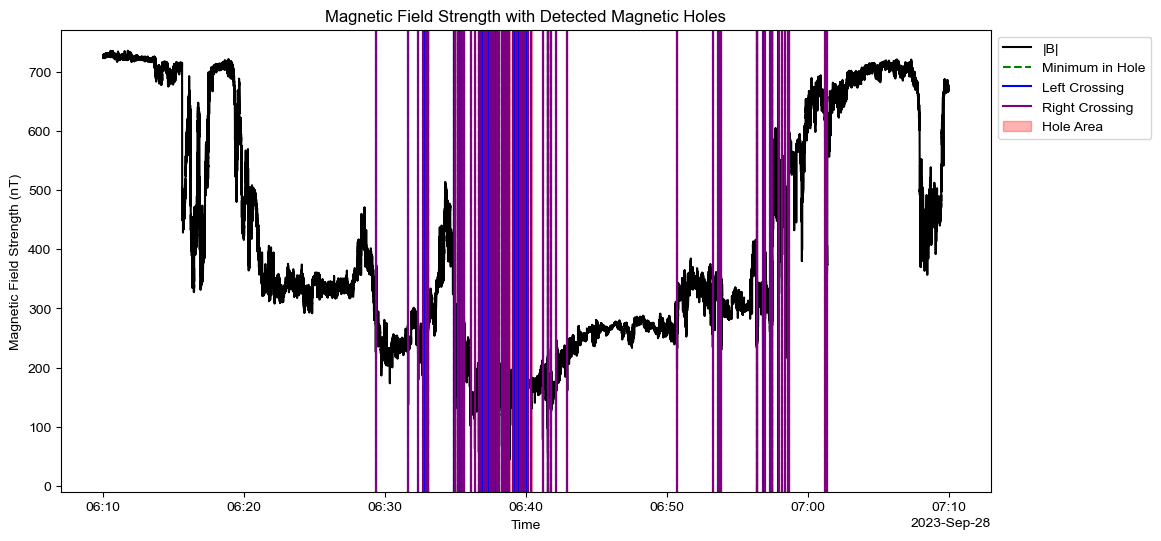

🛟 save_dir = /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output
Settings saved to: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes/magnetic_hole_detection_settings.json
Saving iZotope marker file output
Running setup_output_directory from iZotope_marker_file_output:
Entering setup_output_directory with base_save_dir: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output
Encounter directory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17
Creating encounter directory: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17
Final subdirectory path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
Exiting setup_output_directory, returning: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to_071000_Bmag_Holes
File path: /Users/robertalexander/GitHub/Plotbot/MH_Scan_Output/E17/E17_PSP_FIELDS_2023-09-28_061000_to

Button(description='Show Directory', style=ButtonStyle())

Requested time range: ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000']
Running setup_output_directory from audify without plot
Fetching MAG data (standard res) for ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] using Plotbot and global instance.
[MH_DM_DEBUG] >>> Calling plotbot_get_data with trange=['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] and passing the global_plotbot_mag_rtn instance (id=5764368672).
🛰️ mag_RTN - acquiring all variables
Processing Data Type: mag_RTN...
[CUBBY] 
=== Retrieving mag_rtn from data_cubby ===
[CUBBY] GRAB CALLER: /Users/robertalexander/GitHub/Plotbot/plotbot/get_data.py:258
[CUBBY] GRAB SUCCESS - Retrieved mag_rtn with type <class 'plotbot.data_classes.psp_mag_classes.mag_rtn_class'>
[CUBBY] GRAB OUTPUT - datetime_array type=ndarray, elem_type=datetime64, shape=(1059369,), range=2023-09-28T06:09:52.002628 to 2023-09-28T07:10:07.997686
[CUBBY] GRAB OUTPUT - raw_data keys=['all', 'br', 'bt', 'bn', 'bmag', 'pmag'] | all(list): len

Button(description='Show Directory', style=ButtonStyle())

Button(description='Open |B|', style=ButtonStyle())

Button(description='Open Br', style=ButtonStyle())

Button(description='Open Bt', style=ButtonStyle())

Button(description='Open Bn', style=ButtonStyle())


--- Magnetic Hole Detection Summary ---
🔢 176 Total potential holes identified
✅ 109 Total holes confirmed
🌀 48 Complex/Assymetrical holes
⛔️ 67 Shallow holes
🆗 0 Wide angle holes
🆗 54 Small threshold crosses
🆗 0 Unresolved asymmetric holes
🆗 48 Initially asymmetric holes (resolved)
-------------------------------------
Settings have been saved to a JSON file in the sub-directory.


In [8]:
# ✨✨✨ShInY NeW wOrKiG cOdE cOdE✨✨✨ 


# import importlib

#region Import Modules Block

#endregion


# from hole_counter import hole_counter
#endregion  

# Initialize the counter
hole_counter = Counter()

def detect_magnetic_holes(trange, smoothing_window_seconds, min_max_finding_smooth_window, mean_threshold, search_in_progress_output, Bave_scan_seconds, break_for_assymettry, small_threshold_cross_flag, small_threshold_cross_adjustment, break_for_small_threshold_cross, break_for_complex_hole, derivative_window_seconds, OUTPUT_ZERO_CROSSING_PLOT, SEARCH_IN_PROGRESS_OUTPUT, INSTRUMENT_SAMPLING_RATE, use_calculated_sampling_rate):
    global hole_counter  # Add this line to use the global hole_counter
    
    max_window_seconds = smoothing_window_seconds
    
    # 📈 Data Preparation Step 1: Extend the Time Range
    extended_trange = extend_time_range(trange, max(smoothing_window_seconds, min_max_finding_smooth_window))

    # 📈 Data Preparation Step 2: Download Data for the Extended Range
    times, br, bt, bn, bmag_extended = download_and_prepare_high_res_mag_data(extended_trange)
    print(f"length of bmag_extended is {len(bmag_extended)}")

    # Calculate sampling rate based on the extended data
    total_samples = len(bmag_extended)
    start_time = datetime.strptime(extended_trange[0], '%Y-%m-%d/%H:%M:%S.%f' if '.' in extended_trange[0] else '%Y-%m-%d/%H:%M:%S')
    end_time = datetime.strptime(extended_trange[1], '%Y-%m-%d/%H:%M:%S.%f' if '.' in extended_trange[1] else '%Y-%m-%d/%H:%M:%S')
    duration = end_time - start_time
    duration_seconds = duration.total_seconds()

    if use_calculated_sampling_rate:
        INSTRUMENT_SAMPLING_RATE = total_samples / duration_seconds
        print(f"✳️ Using calculated SR of {INSTRUMENT_SAMPLING_RATE:.2f} Hz")
    else:
        print(f"✳️ Using predefined SR of {INSTRUMENT_SAMPLING_RATE} Hz")

    # 📈 Data Preparation Step 3: Apply smoothing to the bmag data for detection and maxima finding
    bmag_slow_smooth_extended = efficient_moving_average(times, bmag_extended, smoothing_window_seconds, determine_sampling_rate(times, INSTRUMENT_SAMPLING_RATE, True), mean_threshold)
    bmag_fast_smooth_extended = efficient_moving_average(times, bmag_extended, min_max_finding_smooth_window, determine_sampling_rate(times, INSTRUMENT_SAMPLING_RATE, True), mean_threshold)

    # 📈 Data Preparation Step 4: Clip the smoothed data to the original time range
    times_clipped, bmag = clip_to_original_time_range(times, bmag_extended, trange)
    _, bmag_slow_smooth = clip_to_original_time_range(times, bmag_slow_smooth_extended, trange)
    _, bmag_fast_smooth = clip_to_original_time_range(times, bmag_fast_smooth_extended, trange)

    print(f"Post-clipping length of bmag is {len(bmag)}")

    # # Calculate sampling rate
    # total_samples = len(bmag)
    # start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f' if '.' in trange[0] else '%Y-%m-%d/%H:%M:%S')
    # end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f' if '.' in trange[1] else '%Y-%m-%d/%H:%M:%S')
    # duration = end_time - start_time
    # duration_seconds = duration.total_seconds()

    # if USE_CALCULATED_SAMPLING_RATE:
    #     calculated_sampling_rate = total_samples / duration_seconds
    #     INSTRUMENT_SAMPLING_RATE = calculated_sampling_rate
    #     print(f"✳️ Using calculated SR of {INSTRUMENT_SAMPLING_RATE:.2f} Hz")
    # else:
    #     print(f"✳️ Using predefined SR of {INSTRUMENT_SAMPLING_RATE} Hz")

    
    magnetic_holes = []
    hole_minima = []  # To store the minima for plotting
    hole_maxima_pairs = []  # To store the left and right maxima pairs for plotting
    magnetic_hole_details = []  # To store details of each detected magnetic hole
    i = 0

    #----- ✅✅✅ 1: Scan through the data to detect drops below the slow smoothed value-----//
    
    while i < len(bmag):   
        while i < len(bmag) and bmag[i] > bmag_slow_smooth[i]:  # skip over where bmag > bmag_slow_smooth
            i += 1
        if i >= len(bmag):
            break    
        L_threshold_cross = i
        hole_counter['potential'] += 1
        
    #----- ✅✅✅ 2: Continue scanning forward until bmag rises above the slow smoothed value-----// 
        #region Right Threshold Cross Block
        while i < len(bmag) - 1 and bmag[i] < bmag_slow_smooth[i]:
            i += 1
        R_threshold_cross = i

        if R_threshold_cross - L_threshold_cross <= small_threshold_cross_flag:
            hole_counter['small_threshold_cross'] += 1
            if break_for_small_threshold_cross:
                print("-----⛔️ Skipping this small threshold cross.")
                continue  # Skip the remaining processing for this hole and move to the next iteration
            else:
                R_threshold_cross += small_threshold_cross_adjustment
                L_threshold_cross -= small_threshold_cross_adjustment
                print(f"🔥 Hole detection threshold crossed near the bottom of a hole, expanding L & R thresholds for analysis:")
                print(f"New L_threshold_cross: {L_threshold_cross}")
                print(f"New R_threshold_cross: {R_threshold_cross}")
        #endregion

    #----- ✅✅✅ 3: Scan for minimum where bmag[i] < slow smoothed value-----//
        min_idx = np.argmin(bmag[L_threshold_cross:R_threshold_cross + 1]) + L_threshold_cross  # Offset to slice start, end is exclusive so +1
        min_value = bmag[min_idx]
        print(f"Minimum initially identified at {min_idx}")
    
    #----- ✅ 4: Find the left peak (maximum) before the drop using the fast smoothing window-----//
        #region Left Peak Scan Block
        # Move left while the current smoothed value is lower than the previous smoothed value
        L_plateau_scan = L_threshold_cross
        while L_plateau_scan > 0 and bmag_fast_smooth[L_plateau_scan] < bmag_fast_smooth[L_plateau_scan - 1]:
            L_plateau_scan -= 1
        L_avg_inflect = L_plateau_scan

        # If the identified inflection point is too close to the threshold cross, scan further back in time
        if L_threshold_cross - L_avg_inflect < int(1 * determine_sampling_rate(times_clipped, INSTRUMENT_SAMPLING_RATE, True)):
            L_avg_inflect = max(0, L_threshold_cross - int(1 * determine_sampling_rate(times_clipped, INSTRUMENT_SAMPLING_RATE, True)))
            left_max_slice = bmag[L_avg_inflect:L_threshold_cross + 1]
            print(f"Left peak search extended range: {L_avg_inflect} to {L_threshold_cross}, slice length: {len(left_max_slice)}")
        else:
            left_max_slice = bmag[L_avg_inflect:L_threshold_cross + 1]
            print(f"Left peak search range: {L_avg_inflect} to {L_threshold_cross}, slice length: {len(left_max_slice)}")

        if len(left_max_slice) > 0:
            left_max_value_idx = np.argmax(left_max_slice) + L_avg_inflect
            left_max_value = bmag[left_max_value_idx]
            print(f"Left maximum detected at index {left_max_value_idx}, value: {left_max_value}")
        else:
            print("Warning: Empty slice for finding the left maximum.")
            continue  # Skip this hole and move to the next one
        #endregion
        
    #----- ✅ 5: Find the right peak (maximum) after the drop using the fast smoothing window-----//
        #region Right Peak Scan Block
        R_plateau_scan = R_threshold_cross
        while R_plateau_scan < len(bmag_fast_smooth) - 1 and bmag_fast_smooth[R_plateau_scan] < bmag_fast_smooth[R_plateau_scan + 1]:
            R_plateau_scan += 1
        
        R_avg_inflect = R_plateau_scan  # Assign the inflection point index for R
        
        # Now scan the region from R_avg_inflect to R_plateau_scan for the true maximum
        slice_bmag = bmag[R_threshold_cross:R_avg_inflect + 1]
        print(f"Right peak search range: {R_threshold_cross} to {R_avg_inflect}, slice length: {len(slice_bmag)}")
        
        if len(slice_bmag) > 0:
            right_max_value_idx = np.argmax(slice_bmag) + R_threshold_cross
            right_max_value_idx = min(right_max_value_idx, len(bmag) - 1)  # Ensure it's within bounds
            right_max_value = bmag[right_max_value_idx]
            print(f"Right maximum detected at index {right_max_value_idx}, value: {right_max_value}")
        else:
            # Handle the case where the slice is empty
            print(f"Warning: Empty slice for finding the right maximum: R_threshold_cross={R_threshold_cross}, R_avg_inflect={R_avg_inflect}")
            right_max_value_idx = min(R_threshold_cross, len(bmag) - 1)  # Ensure it's within bounds
            right_max_value = bmag[right_max_value_idx]
            break
        #endregion

    #----- ✅ 6: Process Asymmetry-----//
        #region Assymetry Processing
        hole_info = process_asymmetry(
            left_max_value, right_max_value,
            left_max_value_idx, right_max_value_idx,
            L_threshold_cross, R_threshold_cross,
            times_clipped, asymetric_peak_threshold,
            symmetrical_peak_scan_window_in_secs,
            bmag, bmag_slow_smooth, bmag_fast_smooth,
            determine_sampling_rate, INSTRUMENT_SAMPLING_RATE,
            max_window_seconds,
            break_for_assymettry,
            break_for_complex_hole
        )
    
        if hole_info is None:  # If the processing was skipped due to asymmetry
            hole_counter['asymmetric'] += 1
            if break_for_assymettry:
                continue  # Skip to the next iteration
        else:
            if hole_info.get("status") == "complex":
                hole_counter['complex'] += 1
                continue  # Skip to the next iteration

            if hole_info.get("status") == "unresolved_asymmetry":
                hole_counter['unresolved_asymmetry'] += 1
                continue  # Skip to the next iteration

            # If we're here, the hole is either not asymmetric or the asymmetry was resolved
            if hole_info.get("asymmetrical_initial_peaks_flag", False):
                hole_counter['asymmetric_initial'] += 1

            if hole_info.get("complex_hole_flag", True):
                hole_counter['complex_holes'] += 1

            # Update all relevant variables based on the result from process_asymmetry  
            left_max_value_idx = hole_info.get("left_max_value_idx")
            right_max_value_idx = hole_info.get("right_max_value_idx")
            left_max_value = hole_info.get("left_max_value")
            right_max_value = hole_info.get("right_max_value")
            L_threshold_cross = hole_info.get("L_threshold_cross")
            R_threshold_cross = hole_info.get("R_threshold_cross")
            min_idx = hole_info.get("min_idx")
            min_value = hole_info.get("min_value")
            complex_hole_flag = hole_info.get("complex_hole_flag")
        #endregion
                
    #----- ✅ 7: Determine the Bave for Bave_scan_seconds before and after the hole itself (save one value for before and one for after)-----//
        #region Calculate Bave Block
        # Calculate the sampling rate
        sampling_rate = determine_sampling_rate(times_clipped, INSTRUMENT_SAMPLING_RATE, use_calculated_sampling_rate)

        # Convert search seconds into number of samples
        half_second_samples = int(Bave_scan_seconds * sampling_rate)
        
        # Ensure the indices are within bounds
        L_before_idx = max(0, left_max_value_idx - half_second_samples)
        R_after_idx = min(len(bmag) - 1, right_max_value_idx + half_second_samples)
        
        # Calculate Bave before and after the hole
        Bave_before = np.mean(bmag[L_before_idx:left_max_value_idx])
        Bave_after = np.mean(bmag[right_max_value_idx:R_after_idx])
        
        print(f"Bave_before: {Bave_before}, Bave_after: {Bave_after}")
        #endregion
        
    #----- ✅ 8: Calculate hole depth (take the avg of the two before and after values), first absolute hole depth and then relative-----//
        #region Calculate Hole Depth Block
        Bave = (Bave_before + Bave_after) / 2  # Average of the field before and after the hole
        
        # Calculate absolute hole depth
        hole_abs_depth = Bave - min_value
        # Calculate relative hole depth
        hole_percentage_depth = (hole_abs_depth / Bave) * 100
        
        print(f"Absolute Hole Depth: {hole_abs_depth}, Relative Hole Depth: {hole_percentage_depth}%")
        
        # If the relative depth is not greater than depth_percentage_threshold, print a flag as 🇲🇦 too shallow
        if hole_percentage_depth < depth_percentage_threshold * 100:  # Convert threshold to percentage for comparison
            print(f"🇲🇦 Too shallow: relative depth is {hole_percentage_depth}%")
            hole_counter['shallow'] += 1
            # Conditional behavior: If break_for_shallow_hole is enabled, skip this hole and move to the next
            if break_for_shallow_hole:
                print("-----⛔️ Skipping this hole due to insufficient depth.")
                continue  # Skip the remaining processing for this hole and move to the next iteration
        print(f"-----🕳️ Hole relative depth is {hole_percentage_depth:.1f}%")
        #endregion

    #----- ✅ 9: Calculate the hole change angle and redefine hole boundaries based on stdev-----//
        #region Calculate Hole Angle and Boundaries Block
        # Inside the main loop where you're processing holes:
        tS, tE, W_angle = calculate_hole_angle_and_boundaries(
            bmag, br, bt, bn, left_max_value_idx, right_max_value_idx, min_idx, 
            sampling_rate, Bave_window_seconds, wide_angle_threshold, break_for_wide_angle
        )
        
        # If the hole was skipped, continue to the next iteration
        if tS is None or tE is None or W_angle is None:
            hole_counter['wide_angle'] += 1
            if break_for_wide_angle:
                continue
        
        # Update hole_info to include the new boundaries tS and tE
        hole_info.update({"tS": tS, "tE": tE, "W_angle": W_angle})
        #endregion
    #----- ✅ 10: Calculate the number of First Derivative 0 Crossings (with a specified smoothing window) between beginning and end of the hole-----//
        #region Zero Crossing Block 
        zero_crossings, zero_crossings_indices = analyze_derivative_zero_crossings(
            bmag, times_clipped, left_max_value_idx, right_max_value_idx,
            derivative_window_seconds, sampling_rate, mean_threshold,
            OUTPUT_ZERO_CROSSING_PLOT
        )

        # Check if zero crossings exceed the threshold
        if zero_crossings >= threshold_for_derivative_0_crossings_flag:
            print(f"🇲🇦 Too many zero crossings: {zero_crossings} (Threshold: {threshold_for_derivative_0_crossings_flag})")
            hole_counter['derivative_crossings'] += 1
            if break_for_derivative_crossings:
                print("-----⛔️ Skipping this hole due to excessive zero crossings.")
                continue  # Skip the remaining processing for this hole and move to the next iteration

        # Update hole_info with zero crossings data
        hole_info.update({"zero_crossings": zero_crossings})
        #endregion  

    #----- ✅ 11: Store the results-----//
        #region Store Results Block
        # Store the results and flags for the current hole
        magnetic_hole_details.append(hole_info)
        hole_minima.append(hole_info["min_idx"])
        hole_maxima_pairs.append((hole_info["left_max_value_idx"], hole_info["right_max_value_idx"]))
        magnetic_holes.append((hole_info["L_threshold_cross"], hole_info["R_threshold_cross"]))
        

        if search_in_progress_output:
            print(f"-----⭐️ Magnetic hole identified from index {hole_info['left_max_value_idx']} to {hole_info['right_max_value_idx']}")
                
        i = hole_info["R_threshold_cross"] + 1
        hole_counter['confirmed'] += 1
        #endregion
    
    print(f"Returning: {len(magnetic_holes)} holes, {len(hole_minima)} minima, {len(hole_maxima_pairs)} max pairs")
    return magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag,  magnetic_hole_details

#-------- ⚙️ Constants--------//
#region Constants Block
INSTRUMENT_SAMPLING_RATE = 292.9  # Will not be used if use_calculated_sampling_rate = 1
use_calculated_sampling_rate = 1
depth_percentage_threshold = .25
smoothing_window_seconds = 8
derivative_window_seconds = .2
min_max_finding_smooth_window = .3
mean_threshold = 0.8
search_in_progress_output = True
additional_seconds_for_min_search = 0.2
asymetric_peak_threshold = .25
symmetrical_peak_scan_window_in_secs = 2
Bave_scan_seconds = .1
Bave_window_seconds = 20
wide_angle_threshold = 15
small_threshold_cross_flag = 10
small_threshold_cross_adjustment = 10
#endregion

smoothing_window_seconds = 8  # 8-second smoothing for primary detection
derivative_window_seconds = .2  # Window for smoothing before calculating the first derivative

# min_max_finding_smooth_window = .05  # 0.05 was being tried for a special case and seemed to work well...
min_max_finding_smooth_window = .3  # 0.3-second smoothing for detailed max finding, this was the OG

mean_threshold = 0.8  # 80% of the smoothed value
search_in_progress_output = True  # Set to True for detailed output
additional_seconds_for_min_search = 0.2  # Extend the search range

# Define a threshold for peak asymmetry
asymetric_peak_threshold = .25  # 🪐 25% asymmetry threshold, was originally 10
symmetrical_peak_scan_window_in_secs = 2  # Time window to scan for symmetrical peaks in seconds

Bave_scan_seconds = .1

# New constant for wide angle threshold
Bave_window_seconds = 20  # Window size for calculating Bave and delta_B, this is where the angle is calculated
wide_angle_threshold = 15  # 15 degrees threshold for W angle

small_threshold_cross_flag = 10  # Define the small threshold cross (i.e. we only cross the threshold for _ samples)
small_threshold_cross_adjustment = 10  # Define the adjustment when small threshold cross is detected (i.e. widen by _ to help our algorithm)
#endregion

# -------- 🤗 File Output & Plotting Options--------//
#region File Output & Plotting Options Block
OUTPUT_PLOT = 1  # Set to 1 to output the plot
plot_hole_minimum = 0  # Set to 1 to plot green lines at the minimum points within holes
plot_smooth_threshold_crossing = 1  # Set to 1 to plot blue and purple lines at smooth threshold crossings (see mean_threshold defined below)
SAVE_PLOT = 1 #Save the plot to the subdirectory


OUTPUT_ZERO_CROSSING_PLOT = 0 #⛰️

IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN = 1  # Set to 1 to save iZotope formatted output with max and min indices to a .txt file
MARKER_FILE_VERSION = 3  # Version number for marker file
IZOTOPE_MARKER_FILE_OUTPUT = 0

EXPORT_AUDIO_FILES = 1  # Set to 1 to export audio files
AUDIO_SAMPLING_RATE = 22000  # Sampling rate for the audio files

# New Option for Annotated Markers
Marker_Files_With_Annotated_Markers = 0  # Set to 1 to include drop percentage and width in marker name
Marker_Files_With_Hole_Numbers = 0

SEARCH_IN_PROGRESS_OUTPUT = 1

#-------- 📈 Plotting Options --------//
plot_hole_minimum = 1  # 1 to plot minima, 0 to skip
plot_smooth_threshold_crossing = 1  # 1 to plot threshold crossings, 0 to skip
#endregion

#-------- 🇲🇦 Flag Handling--------//
#region Flag Handling Block 
break_for_shallow_hole = 1 # 🇲🇦 flag for skipping if a hole is too shallow
break_for_assymettry = 0 # 🇲🇦 flag for skipping if a whole is assymetrical
break_for_wide_angle = 0  # 🇲🇦 flag for handling wide angle cases
break_for_small_threshold_cross = 0  # 🇲🇦 flag to skip small threshold crosses
break_for_complex_hole = 0 # 🇲🇦 flag for skipping complex holes
threshold_for_derivative_0_crossings_flag = 1000 #If the .1s smoothed first derivative crosses this many times or higher, raise a flag
break_for_derivative_crossings = 0
#endregion

#--------⏱️ Set time range--------//
#region Time Range Block
# Define the input parameters
trange = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] #Whole Shebang
trange = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] #Whole Shebang
# trange = ['2023-09-28/06:37:15.000', '2023-09-28/06:37:45.000'] #wide lots o dips
# trange = ['2023-09-28/06:37:05.500', '2023-09-28/06:37:08.000'] #Interesting Test Case WE'VE BEEN USING for Derivative
# trange = ['2023-09-28/06:39:00.000', '2023-09-28/06:40:10.000'] #⭐️⭐️⭐️ GREAT region for solid hole testing⭐️⭐️⭐️
# trange = ['2023-09-28/06:38:10.000', '2023-09-28/06:40:10.000'] #⭐️⭐️⭐️ GREAT region for solid hole testing⭐️⭐️⭐️
# trange = ['2023-09-28/06:39:07.000', '2023-09-28/06:39:10.000'] #WONKY WONKS
# trange = ['2023-09-28/06:39:50.000', '2023-09-28/06:39:55.000'] #⭐️⭐️⭐️ Checking a single hole
# trange = ['2023-09-28/06:39:31.000', '2023-09-28/06:39:35.000'] #⭐️⭐️⭐️ PERFECT Single hole for testing⭐️⭐️⭐️
# trange = ['2023-09-28/06:39:45.000', '2023-09-28/06:39:50.000'] #⭐️⭐️⭐️ ANOTHER PERFECT Single hole for testing⭐️⭐️⭐️
# trange = ['2023-09-28/06:37:05.500', '2023-09-28/06:37:08.000'] #Interesting Test Case WE'VE BEEN USING for Derivative
# trange = ['2023-09-28/06:36:022', '2023-09-28/06:36:24'] # A pretty hole ⭐️
# trange = ['2023-09-28/06:29:18', '2023-09-28/06:29:22'] #with a larger window #🇲🇦 Asymmetry between peaks: 42.25%
#endregion

time_check(trange)

# At the beginning of your main script, after setting up save_dir
sub_save_dir = setup_output_directory(trange, save_dir)
print(f"🙌🙌🙌Main script: sub_save_dir set to {sub_save_dir}")

# Call the function to detect magnetic holes
magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag, magnetic_hole_details = detect_magnetic_holes(
    trange, 
    smoothing_window_seconds, 
    min_max_finding_smooth_window, 
    mean_threshold, 
    search_in_progress_output, 
    Bave_scan_seconds, 
    break_for_assymettry, 
    small_threshold_cross_flag,          
    small_threshold_cross_adjustment,    
    break_for_small_threshold_cross,     
    break_for_complex_hole,
    derivative_window_seconds,  # Pass the derivative window into the function
    OUTPUT_ZERO_CROSSING_PLOT,
    SEARCH_IN_PROGRESS_OUTPUT,
    INSTRUMENT_SAMPLING_RATE,
    use_calculated_sampling_rate
    
)

# Plotting the results if configured
if OUTPUT_PLOT:
    plot_mag_data_with_holes_and_minimum(
        times_clipped, 
        bmag, 
        magnetic_holes, 
        hole_minima, 
        hole_maxima_pairs, 
        plot_hole_minimum, 
        plot_smooth_threshold_crossing,
        trange,  # Add this
        save_dir,  # Add this
        SAVE_PLOT  # Add this if you don't want to save the plot by default
    )
# Create the settings dictionary
settings = {
    "INSTRUMENT_SAMPLING_RATE": INSTRUMENT_SAMPLING_RATE,
    "use_calculated_sampling_rate": use_calculated_sampling_rate,
    "depth_percentage_threshold": depth_percentage_threshold,
    "smoothing_window_seconds": smoothing_window_seconds,
    "derivative_window_seconds": derivative_window_seconds,
    "min_max_finding_smooth_window": min_max_finding_smooth_window,
    "mean_threshold": mean_threshold,
    "search_in_progress_output": search_in_progress_output,
    "additional_seconds_for_min_search": additional_seconds_for_min_search,
    "asymetric_peak_threshold": asymetric_peak_threshold,
    "symmetrical_peak_scan_window_in_secs": symmetrical_peak_scan_window_in_secs,
    "Bave_scan_seconds": Bave_scan_seconds,
    "Bave_window_seconds": Bave_window_seconds,
    "wide_angle_threshold": wide_angle_threshold,
    "small_threshold_cross_flag": small_threshold_cross_flag,
    "small_threshold_cross_adjustment": small_threshold_cross_adjustment,
    "OUTPUT_PLOT": OUTPUT_PLOT,
    "plot_hole_minimum": plot_hole_minimum,
    "plot_smooth_threshold_crossing": plot_smooth_threshold_crossing,
    "OUTPUT_ZERO_CROSSING_PLOT": OUTPUT_ZERO_CROSSING_PLOT,
    "IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN": IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN,
    "MARKER_FILE_VERSION": MARKER_FILE_VERSION,
    "IZOTOPE_MARKER_FILE_OUTPUT": IZOTOPE_MARKER_FILE_OUTPUT,
    "EXPORT_AUDIO_FILES": EXPORT_AUDIO_FILES,
    "AUDIO_SAMPLING_RATE": AUDIO_SAMPLING_RATE,
    "Marker_Files_With_Annotated_Markers": Marker_Files_With_Annotated_Markers,
    "SEARCH_IN_PROGRESS_OUTPUT": SEARCH_IN_PROGRESS_OUTPUT,
    "break_for_shallow_hole": break_for_shallow_hole,
    "break_for_assymettry": break_for_assymettry,
    "break_for_wide_angle": break_for_wide_angle,
    "break_for_small_threshold_cross": break_for_small_threshold_cross,
    "break_for_complex_hole": break_for_complex_hole,
    "threshold_for_derivative_0_crossings_flag": threshold_for_derivative_0_crossings_flag,
    "break_for_derivative_crossings": break_for_derivative_crossings
}

# Get the sub-directory path
# sub_save_dir = setup_output_directory(trange, save_dir)

# last_dir_file = "last_selected_dir.txt"
# save_dir = set_save_directory(last_dir_file)
print(f'🛟 save_dir = {save_dir}')

# Use sub_save_dir for all file operations
settings_file_path = os.path.join(sub_save_dir, 'magnetic_hole_detection_settings.json')
with open(settings_file_path, 'w') as f:
    json.dump(settings, f, indent=4)

print(f"Settings saved to: {settings_file_path}")

# Generate marker file if needed
if IZOTOPE_MARKER_FILE_OUTPUT or IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN:
    # Call the output_magnetic_holes function with the settings dictionary
    output_magnetic_holes(
        magnetic_holes,
        hole_maxima_pairs,
        times_clipped,
        bmag,
        IZOTOPE_MARKER_FILE_OUTPUT,
        IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN,
        trange,
        MARKER_FILE_VERSION,
        SEARCH_IN_PROGRESS_OUTPUT,
        save_dir,
        INSTRUMENT_SAMPLING_RATE,
        Marker_Files_With_Annotated_Markers,
        Marker_Files_With_Hole_Numbers,
        magnetic_hole_details
    )

# Export audio files if needed
if EXPORT_AUDIO_FILES:
    audify_high_res_mag_data_without_plot(trange[0], trange[1], sub_save_dir, AUDIO_SAMPLING_RATE, sub_save_dir)

# Summary print statements
print("\n--- Magnetic Hole Detection Summary ---")
print(f"🔢 {hole_counter['potential']} Total potential holes identified")
print(f"✅ {hole_counter['confirmed']} Total holes confirmed")
print(f"🌀 {hole_counter['complex_holes']} Complex/Assymetrical holes")
print(f"{'⛔️' if break_for_shallow_hole else '🆗'} {hole_counter['shallow']} Shallow holes")
# print(f"{'⛔️' if break_for_assymettry else '🆗'} {hole_counter['asymmetric']} Asymmetric holes")
print(f"{'⛔️' if break_for_wide_angle else '🆗'} {hole_counter['wide_angle']} Wide angle holes")
print(f"{'⛔️' if break_for_small_threshold_cross else '🆗'} {hole_counter['small_threshold_cross']} Small threshold crosses")
print(f"{'⛔️' if break_for_assymettry else '🆗'} {hole_counter['unresolved_asymmetry']} Unresolved asymmetric holes")
print(f"🆗 {hole_counter['asymmetric_initial']} Initially asymmetric holes (resolved)")
# print(f"🆗 {hole_counter['complex_resolved']} Complex holes (resolved)")
# print(f"{'⛔️' if break_for_complex_hole else '🆗'} {hole_counter.get('complex', 0)} Complex holes")
# print(f"{'⛔️' if break_for_derivative_crossings else '🆗'} {hole_counter['derivative_crossings']} Excessive derivative crossings")
print("-------------------------------------")

print("Settings have been saved to a JSON file in the sub-directory.")



In [ ]:
#FOR SAVING AUDIO **NOT WORKING**
global save_dir

import importlib

#region Import Modules Block
from collections import Counter
import asymmetry_calc
importlib.reload(asymmetry_calc)
from asymmetry_calc import *
import time_management
importlib.reload(time_management)
from time_management import *
import data_management
importlib.reload(data_management)
from data_management import *
import plotting
importlib.reload(plotting)
from plotting import *
import data_management
importlib.reload(data_management)
from data_management import *
import data_audification
importlib.reload(data_audification)
from data_audification import *
import plotting
importlib.reload(plotting)
from plotting import *
import zero_crossing_analysis
importlib.reload(zero_crossing_analysis)
from zero_crossing_analysis import analyze_derivative_zero_crossings
import MH_format_output
importlib.reload(MH_format_output)
from MH_format_output import *

import hole_angle_calc
importlib.reload(hole_angle_calc)
from hole_angle_calc import *


# from hole_counter import hole_counter
#endregion  

# Initialize the counter
hole_counter = Counter()

def detect_magnetic_holes(trange, smoothing_window_seconds, min_max_finding_smooth_window, mean_threshold, search_in_progress_output, Bave_scan_seconds, break_for_assymettry, small_threshold_cross_flag, small_threshold_cross_adjustment, break_for_small_threshold_cross, break_for_complex_hole, derivative_window_seconds, OUTPUT_ZERO_CROSSING_PLOT, SEARCH_IN_PROGRESS_OUTPUT, INSTRUMENT_SAMPLING_RATE, use_calculated_sampling_rate):
    global hole_counter  # Add this line to use the global hole_counter
    
    max_window_seconds = smoothing_window_seconds
    
    # 📈 Data Preparation Step 1: Extend the Time Range
    extended_trange = extend_time_range(trange, max(smoothing_window_seconds, min_max_finding_smooth_window))

    # 📈 Data Preparation Step 2: Download Data for the Extended Range
    times, br, bt, bn, bmag_extended = download_and_prepare_high_res_mag_data(extended_trange)
    print(f"length of bmag_extended is {len(bmag_extended)}")

    # Calculate sampling rate based on the extended data
    total_samples = len(bmag_extended)
    start_time = datetime.strptime(extended_trange[0], '%Y-%m-%d/%H:%M:%S.%f' if '.' in extended_trange[0] else '%Y-%m-%d/%H:%M:%S')
    end_time = datetime.strptime(extended_trange[1], '%Y-%m-%d/%H:%M:%S.%f' if '.' in extended_trange[1] else '%Y-%m-%d/%H:%M:%S')
    duration = end_time - start_time
    duration_seconds = duration.total_seconds()

    if use_calculated_sampling_rate:
        INSTRUMENT_SAMPLING_RATE = total_samples / duration_seconds
        print(f"✳️ Using calculated SR of {INSTRUMENT_SAMPLING_RATE:.2f} Hz")
    else:
        print(f"✳️ Using predefined SR of {INSTRUMENT_SAMPLING_RATE} Hz")

    # 📈 Data Preparation Step 3: Apply smoothing to the bmag data for detection and maxima finding
    bmag_slow_smooth_extended = efficient_moving_average(times, bmag_extended, smoothing_window_seconds, determine_sampling_rate(times, INSTRUMENT_SAMPLING_RATE, True), mean_threshold)
    bmag_fast_smooth_extended = efficient_moving_average(times, bmag_extended, min_max_finding_smooth_window, determine_sampling_rate(times, INSTRUMENT_SAMPLING_RATE, True), mean_threshold)

    # 📈 Data Preparation Step 4: Clip the smoothed data to the original time range
    times_clipped, bmag = clip_to_original_time_range(times, bmag_extended, trange)
    _, bmag_slow_smooth = clip_to_original_time_range(times, bmag_slow_smooth_extended, trange)
    _, bmag_fast_smooth = clip_to_original_time_range(times, bmag_fast_smooth_extended, trange)

    print(f"Post-clipping length of bmag is {len(bmag)}")

    # # Calculate sampling rate
    # total_samples = len(bmag)
    # start_time = datetime.strptime(trange[0], '%Y-%m-%d/%H:%M:%S.%f' if '.' in trange[0] else '%Y-%m-%d/%H:%M:%S')
    # end_time = datetime.strptime(trange[1], '%Y-%m-%d/%H:%M:%S.%f' if '.' in trange[1] else '%Y-%m-%d/%H:%M:%S')
    # duration = end_time - start_time
    # duration_seconds = duration.total_seconds()

    # if USE_CALCULATED_SAMPLING_RATE:
    #     calculated_sampling_rate = total_samples / duration_seconds
    #     INSTRUMENT_SAMPLING_RATE = calculated_sampling_rate
    #     print(f"✳️ Using calculated SR of {INSTRUMENT_SAMPLING_RATE:.2f} Hz")
    # else:
    #     print(f"✳️ Using predefined SR of {INSTRUMENT_SAMPLING_RATE} Hz")

    
    magnetic_holes = []
    hole_minima = []  # To store the minima for plotting
    hole_maxima_pairs = []  # To store the left and right maxima pairs for plotting
    magnetic_hole_details = []  # To store details of each detected magnetic hole
    i = 0

    #----- ✅✅✅ 1: Scan through the data to detect drops below the slow smoothed value-----//
    
    while i < len(bmag):   
        while i < len(bmag) and bmag[i] > bmag_slow_smooth[i]:  # skip over where bmag > bmag_slow_smooth
            i += 1
        if i >= len(bmag):
            break    
        L_threshold_cross = i
        hole_counter['potential'] += 1
        
    #----- ✅✅✅ 2: Continue scanning forward until bmag rises above the slow smoothed value-----// 
        #region Right Threshold Cross Block
        while i < len(bmag) - 1 and bmag[i] < bmag_slow_smooth[i]:
            i += 1
        R_threshold_cross = i

        if R_threshold_cross - L_threshold_cross <= small_threshold_cross_flag:
            hole_counter['small_threshold_cross'] += 1
            if break_for_small_threshold_cross:
                print("-----⛔️ Skipping this small threshold cross.")
                continue  # Skip the remaining processing for this hole and move to the next iteration
            else:
                R_threshold_cross += small_threshold_cross_adjustment
                L_threshold_cross -= small_threshold_cross_adjustment
                print(f"🔥 Hole detection threshold crossed near the bottom of a hole, expanding L & R thresholds for analysis:")
                print(f"New L_threshold_cross: {L_threshold_cross}")
                print(f"New R_threshold_cross: {R_threshold_cross}")
        #endregion

    #----- ✅✅✅ 3: Scan for minimum where bmag[i] < slow smoothed value-----//
        min_idx = np.argmin(bmag[L_threshold_cross:R_threshold_cross + 1]) + L_threshold_cross  # Offset to slice start, end is exclusive so +1
        min_value = bmag[min_idx]
        print(f"Minimum initially identified at {min_idx}")
    
    #----- ✅ 4: Find the left peak (maximum) before the drop using the fast smoothing window-----//
        #region Left Peak Scan Block
        # Move left while the current smoothed value is lower than the previous smoothed value
        L_plateau_scan = L_threshold_cross
        while L_plateau_scan > 0 and bmag_fast_smooth[L_plateau_scan] < bmag_fast_smooth[L_plateau_scan - 1]:
            L_plateau_scan -= 1
        L_avg_inflect = L_plateau_scan

        # If the identified inflection point is too close to the threshold cross, scan further back in time
        if L_threshold_cross - L_avg_inflect < int(1 * determine_sampling_rate(times_clipped, INSTRUMENT_SAMPLING_RATE, True)):
            L_avg_inflect = max(0, L_threshold_cross - int(1 * determine_sampling_rate(times_clipped, INSTRUMENT_SAMPLING_RATE, True)))
            left_max_slice = bmag[L_avg_inflect:L_threshold_cross + 1]
            print(f"Left peak search extended range: {L_avg_inflect} to {L_threshold_cross}, slice length: {len(left_max_slice)}")
        else:
            left_max_slice = bmag[L_avg_inflect:L_threshold_cross + 1]
            print(f"Left peak search range: {L_avg_inflect} to {L_threshold_cross}, slice length: {len(left_max_slice)}")

        if len(left_max_slice) > 0:
            left_max_value_idx = np.argmax(left_max_slice) + L_avg_inflect
            left_max_value = bmag[left_max_value_idx]
            print(f"Left maximum detected at index {left_max_value_idx}, value: {left_max_value}")
        else:
            print("Warning: Empty slice for finding the left maximum.")
            continue  # Skip this hole and move to the next one
        #endregion
        
    #----- ✅ 5: Find the right peak (maximum) after the drop using the fast smoothing window-----//
        #region Right Peak Scan Block
        R_plateau_scan = R_threshold_cross
        while R_plateau_scan < len(bmag_fast_smooth) - 1 and bmag_fast_smooth[R_plateau_scan] < bmag_fast_smooth[R_plateau_scan + 1]:
            R_plateau_scan += 1
        
        R_avg_inflect = R_plateau_scan  # Assign the inflection point index for R
        
        # Now scan the region from R_avg_inflect to R_plateau_scan for the true maximum
        slice_bmag = bmag[R_threshold_cross:R_avg_inflect + 1]
        print(f"Right peak search range: {R_threshold_cross} to {R_avg_inflect}, slice length: {len(slice_bmag)}")
        
        if len(slice_bmag) > 0:
            right_max_value_idx = np.argmax(slice_bmag) + R_threshold_cross
            right_max_value_idx = min(right_max_value_idx, len(bmag) - 1)  # Ensure it's within bounds
            right_max_value = bmag[right_max_value_idx]
            print(f"Right maximum detected at index {right_max_value_idx}, value: {right_max_value}")
        else:
            # Handle the case where the slice is empty
            print(f"Warning: Empty slice for finding the right maximum: R_threshold_cross={R_threshold_cross}, R_avg_inflect={R_avg_inflect}")
            right_max_value_idx = min(R_threshold_cross, len(bmag) - 1)  # Ensure it's within bounds
            right_max_value = bmag[right_max_value_idx]
            break
        #endregion

    #----- ✅ 6: Process Asymmetry-----//
        #region Assymetry Processing
        hole_info = process_asymmetry(
            left_max_value, right_max_value,
            left_max_value_idx, right_max_value_idx,
            L_threshold_cross, R_threshold_cross,
            times_clipped, asymetric_peak_threshold,
            symmetrical_peak_scan_window_in_secs,
            bmag, bmag_slow_smooth, bmag_fast_smooth,
            determine_sampling_rate, INSTRUMENT_SAMPLING_RATE,
            max_window_seconds,
            break_for_assymettry,
            break_for_complex_hole
        )
    
        if hole_info is None:  # If the processing was skipped due to asymmetry
            hole_counter['asymmetric'] += 1
            if break_for_assymettry:
                continue  # Skip to the next iteration
        else:
            if hole_info.get("status") == "complex":
                hole_counter['complex'] += 1
                continue  # Skip to the next iteration

            if hole_info.get("status") == "unresolved_asymmetry":
                hole_counter['unresolved_asymmetry'] += 1
                continue  # Skip to the next iteration

            # If we're here, the hole is either not asymmetric or the asymmetry was resolved
            if hole_info.get("asymmetrical_initial_peaks_flag", False):
                hole_counter['asymmetric_initial'] += 1

            if hole_info.get("complex_hole_flag", True):
                hole_counter['complex_holes'] += 1

            # Update all relevant variables based on the result from process_asymmetry  
            left_max_value_idx = hole_info.get("left_max_value_idx")
            right_max_value_idx = hole_info.get("right_max_value_idx")
            left_max_value = hole_info.get("left_max_value")
            right_max_value = hole_info.get("right_max_value")
            L_threshold_cross = hole_info.get("L_threshold_cross")
            R_threshold_cross = hole_info.get("R_threshold_cross")
            min_idx = hole_info.get("min_idx")
            min_value = hole_info.get("min_value")
            complex_hole_flag = hole_info.get("complex_hole_flag")
        #endregion
                
    #----- ✅ 7: Determine the Bave for Bave_scan_seconds before and after the hole itself (save one value for before and one for after)-----//
        #region Calculate Bave Block
        # Calculate the sampling rate
        sampling_rate = determine_sampling_rate(times_clipped, INSTRUMENT_SAMPLING_RATE, use_calculated_sampling_rate)

        # Convert search seconds into number of samples
        half_second_samples = int(Bave_scan_seconds * sampling_rate)
        
        # Ensure the indices are within bounds
        L_before_idx = max(0, left_max_value_idx - half_second_samples)
        R_after_idx = min(len(bmag) - 1, right_max_value_idx + half_second_samples)
        
        # Calculate Bave before and after the hole
        Bave_before = np.mean(bmag[L_before_idx:left_max_value_idx])
        Bave_after = np.mean(bmag[right_max_value_idx:R_after_idx])
        
        print(f"Bave_before: {Bave_before}, Bave_after: {Bave_after}")
        #endregion
        
    #----- ✅ 8: Calculate hole depth (take the avg of the two before and after values), first absolute hole depth and then relative-----//
        #region Calculate Hole Depth Block
        Bave = (Bave_before + Bave_after) / 2  # Average of the field before and after the hole
        
        # Calculate absolute hole depth
        hole_abs_depth = Bave - min_value
        # Calculate relative hole depth
        hole_percentage_depth = (hole_abs_depth / Bave) * 100
        
        print(f"Absolute Hole Depth: {hole_abs_depth}, Relative Hole Depth: {hole_percentage_depth}%")
        
        # If the relative depth is not greater than depth_percentage_threshold, print a flag as 🇲🇦 too shallow
        if hole_percentage_depth < depth_percentage_threshold * 100:  # Convert threshold to percentage for comparison
            print(f"🇲🇦 Too shallow: relative depth is {hole_percentage_depth}%")
            hole_counter['shallow'] += 1
            # Conditional behavior: If break_for_shallow_hole is enabled, skip this hole and move to the next
            if break_for_shallow_hole:
                print("-----⛔️ Skipping this hole due to insufficient depth.")
                continue  # Skip the remaining processing for this hole and move to the next iteration
        print(f"-----🕳️ Hole relative depth is {hole_percentage_depth:.1f}%")
        #endregion

    #----- ✅ 9: Calculate the hole change angle and redefine hole boundaries based on stdev-----//
        #region Calculate Hole Angle and Boundaries Block
        # Inside the main loop where you're processing holes:
        tS, tE, W_angle = calculate_hole_angle_and_boundaries(
            bmag, br, bt, bn, left_max_value_idx, right_max_value_idx, min_idx, 
            sampling_rate, Bave_window_seconds, wide_angle_threshold, break_for_wide_angle
        )
        
        # If the hole was skipped, continue to the next iteration
        if tS is None or tE is None or W_angle is None:
            hole_counter['wide_angle'] += 1
            if break_for_wide_angle:
                continue
        
        # Update hole_info to include the new boundaries tS and tE
        hole_info.update({"tS": tS, "tE": tE, "W_angle": W_angle})
        #endregion
    #----- ✅ 10: Calculate the number of First Derivative 0 Crossings (with a specified smoothing window) between beginning and end of the hole-----//
        #region Zero Crossing Block 
        zero_crossings, zero_crossings_indices = analyze_derivative_zero_crossings(
            bmag, times_clipped, left_max_value_idx, right_max_value_idx,
            derivative_window_seconds, sampling_rate, mean_threshold,
            OUTPUT_ZERO_CROSSING_PLOT
        )

        # Check if zero crossings exceed the threshold
        if zero_crossings >= threshold_for_derivative_0_crossings_flag:
            print(f"🇲🇦 Too many zero crossings: {zero_crossings} (Threshold: {threshold_for_derivative_0_crossings_flag})")
            hole_counter['derivative_crossings'] += 1
            if break_for_derivative_crossings:
                print("-----⛔️ Skipping this hole due to excessive zero crossings.")
                continue  # Skip the remaining processing for this hole and move to the next iteration

        # Update hole_info with zero crossings data
        hole_info.update({"zero_crossings": zero_crossings})
        #endregion  

    #----- ✅ 11: Store the results-----//
        #region Store Results Block
        # Store the results and flags for the current hole
        magnetic_hole_details.append(hole_info)
        hole_minima.append(hole_info["min_idx"])
        hole_maxima_pairs.append((hole_info["left_max_value_idx"], hole_info["right_max_value_idx"]))
        magnetic_holes.append((hole_info["L_threshold_cross"], hole_info["R_threshold_cross"]))
        

        if search_in_progress_output:
            print(f"-----⭐️ Magnetic hole identified from index {hole_info['left_max_value_idx']} to {hole_info['right_max_value_idx']}")
                
        i = hole_info["R_threshold_cross"] + 1
        hole_counter['confirmed'] += 1
        #endregion
    
    print(f"Returning: {len(magnetic_holes)} holes, {len(hole_minima)} minima, {len(hole_maxima_pairs)} max pairs")
    return magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag,  magnetic_hole_details

#-------- ⚙️ Constants--------//
#region Constants Block
INSTRUMENT_SAMPLING_RATE = 292.9  # Will not be used if use_calculated_sampling_rate = 1
use_calculated_sampling_rate = 1
depth_percentage_threshold = .25
smoothing_window_seconds = 8
derivative_window_seconds = .2
min_max_finding_smooth_window = .3
mean_threshold = 0.8
search_in_progress_output = True
additional_seconds_for_min_search = 0.2
asymetric_peak_threshold = .25
symmetrical_peak_scan_window_in_secs = 2
Bave_scan_seconds = .1
Bave_window_seconds = 20
wide_angle_threshold = 15
small_threshold_cross_flag = 10
small_threshold_cross_adjustment = 10
#endregion

smoothing_window_seconds = 8  # 8-second smoothing for primary detection
derivative_window_seconds = .2  # Window for smoothing before calculating the first derivative

# min_max_finding_smooth_window = .05  # 0.05 was being tried for a special case and seemed to work well...
min_max_finding_smooth_window = .3  # 0.3-second smoothing for detailed max finding, this was the OG

mean_threshold = 0.8  # 80% of the smoothed value
search_in_progress_output = True  # Set to True for detailed output
additional_seconds_for_min_search = 0.2  # Extend the search range

# Define a threshold for peak asymmetry
asymetric_peak_threshold = .25  # 🪐 25% asymmetry threshold, was originally 10
symmetrical_peak_scan_window_in_secs = 2  # Time window to scan for symmetrical peaks in seconds

Bave_scan_seconds = .1

# New constant for wide angle threshold
Bave_window_seconds = 20  # Window size for calculating Bave and delta_B, this is where the angle is calculated
wide_angle_threshold = 15  # 15 degrees threshold for W angle

small_threshold_cross_flag = 10  # Define the small threshold cross (i.e. we only cross the threshold for _ samples)
small_threshold_cross_adjustment = 10  # Define the adjustment when small threshold cross is detected (i.e. widen by _ to help our algorithm)
#endregion

# -------- 🤗 File Output & Plotting Options--------//
#region File Output & Plotting Options Block
OUTPUT_PLOT = 1  # Set to 1 to output the plot
plot_hole_minimum = 0  # Set to 1 to plot green lines at the minimum points within holes
plot_smooth_threshold_crossing = 1  # Set to 1 to plot blue and purple lines at smooth threshold crossings (see mean_threshold defined below)
SAVE_PLOT = 1 #Save the plot to the subdirectory


OUTPUT_ZERO_CROSSING_PLOT = 0 #⛰️

IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN = 1  # Set to 1 to save iZotope formatted output with max and min indices to a .txt file
MARKER_FILE_VERSION = 3  # Version number for marker file
IZOTOPE_MARKER_FILE_OUTPUT = 0

EXPORT_AUDIO_FILES = 1  # Set to 1 to export audio files
AUDIO_SAMPLING_RATE = 22000  # Sampling rate for the audio files

# New Option for Annotated Markers
Marker_Files_With_Annotated_Markers = 0  # Set to 1 to include drop percentage and width in marker name
Marker_Files_With_Hole_Numbers = 0

SEARCH_IN_PROGRESS_OUTPUT = 1

#-------- 📈 Plotting Options --------//
plot_hole_minimum = 1  # 1 to plot minima, 0 to skip
plot_smooth_threshold_crossing = 1  # 1 to plot threshold crossings, 0 to skip
#endregion

#-------- 🇲🇦 Flag Handling--------//
#region Flag Handling Block 
break_for_shallow_hole = 1 # 🇲🇦 flag for skipping if a hole is too shallow
break_for_assymettry = 0 # 🇲🇦 flag for skipping if a whole is assymetrical
break_for_wide_angle = 0  # 🇲🇦 flag for handling wide angle cases
break_for_small_threshold_cross = 0  # 🇲🇦 flag to skip small threshold crosses
break_for_complex_hole = 0 # 🇲🇦 flag for skipping complex holes
threshold_for_derivative_0_crossings_flag = 1000 #If the .1s smoothed first derivative crosses this many times or higher, raise a flag
break_for_derivative_crossings = 0
#endregion

#--------⏱️ Set time range--------//
#region Time Range Block
# Define the input parameters
# trange = ['2023-09-28/06:10:00.000', '2023-09-28/07:10:00.000'] #Whole Shebang
# trange = ['2023-09-28/06:37:15.000', '2023-09-28/06:37:45.000'] #wide lots o dips
# trange = ['2023-09-28/06:37:05.500', '2023-09-28/06:37:08.000'] #Interesting Test Case WE'VE BEEN USING for Derivative
trange = ['2023-09-28/06:39:00.000', '2023-09-28/06:40:10.000'] #⭐️⭐️⭐️ GREAT region for solid hole testing⭐️⭐️⭐️
# trange = ['2022-09-05/14:00:00.000', '2022-09-05/20:00:00.000'] #⭐️⭐️⭐️ GREAT region for solid hole testing⭐️⭐️⭐️

# # # E13 CME Region
# rangeStart = '2022/09/05 14:00:00.000'
# rangeStop = '2022/09/05  20:00:00.000'

# trange = ['2023-09-28/06:39:07.000', '2023-09-28/06:39:10.000'] #WONKY WONKS
# trange = ['2023-09-28/06:39:50.000', '2023-09-28/06:39:55.000'] #⭐️⭐️⭐️ Checking a single hole
# trange = ['2023-09-28/06:39:31.000', '2023-09-28/06:39:35.000'] #⭐️⭐️⭐️ PERFECT Single hole for testing⭐️⭐️⭐️
# trange = ['2023-09-28/06:39:45.000', '2023-09-28/06:39:50.000'] #⭐️⭐️⭐️ ANOTHER PERFECT Single hole for testing⭐️⭐️⭐️
# trange = ['2023-09-28/06:37:05.500', '2023-09-28/06:37:08.000'] #Interesting Test Case WE'VE BEEN USING for Derivative
# trange = ['2023-09-28/06:36:022', '2023-09-28/06:36:24'] # A pretty hole ⭐️
# trange = ['2023-09-28/06:29:18', '2023-09-28/06:29:22'] #with a larger window #🇲🇦 Asymmetry between peaks: 42.25%
#endregion

time_check(trange)

# At the beginning of your main script, after setting up save_dir
sub_save_dir = setup_output_directory(trange, save_dir)
print(f"🙌🙌🙌Main script: sub_save_dir set to {sub_save_dir}")

# # Call the function to detect magnetic holes
# magnetic_holes, hole_minima, hole_maxima_pairs, times_clipped, bmag, magnetic_hole_details = detect_magnetic_holes(
#     trange, 
#     smoothing_window_seconds, 
#     min_max_finding_smooth_window, 
#     mean_threshold, 
#     search_in_progress_output, 
#     Bave_scan_seconds, 
#     break_for_assymettry, 
#     small_threshold_cross_flag,          
#     small_threshold_cross_adjustment,    
#     break_for_small_threshold_cross,     
#     break_for_complex_hole,
#     derivative_window_seconds,  # Pass the derivative window into the function
#     OUTPUT_ZERO_CROSSING_PLOT,
#     SEARCH_IN_PROGRESS_OUTPUT,
#     INSTRUMENT_SAMPLING_RATE,
#     use_calculated_sampling_rate
    
# )

# # Plotting the results if configured
# if OUTPUT_PLOT:
#     plot_mag_data_with_holes_and_minimum(
#         times_clipped, 
#         bmag, 
#         magnetic_holes, 
#         hole_minima, 
#         hole_maxima_pairs, 
#         plot_hole_minimum, 
#         plot_smooth_threshold_crossing,
#         trange,  # Add this
#         save_dir,  # Add this
#         SAVE_PLOT  # Add this if you don't want to save the plot by default
#     )
# # Create the settings dictionary
# settings = {
#     "INSTRUMENT_SAMPLING_RATE": INSTRUMENT_SAMPLING_RATE,
#     "use_calculated_sampling_rate": use_calculated_sampling_rate,
#     "depth_percentage_threshold": depth_percentage_threshold,
#     "smoothing_window_seconds": smoothing_window_seconds,
#     "derivative_window_seconds": derivative_window_seconds,
#     "min_max_finding_smooth_window": min_max_finding_smooth_window,
#     "mean_threshold": mean_threshold,
#     "search_in_progress_output": search_in_progress_output,
#     "additional_seconds_for_min_search": additional_seconds_for_min_search,
#     "asymetric_peak_threshold": asymetric_peak_threshold,
#     "symmetrical_peak_scan_window_in_secs": symmetrical_peak_scan_window_in_secs,
#     "Bave_scan_seconds": Bave_scan_seconds,
#     "Bave_window_seconds": Bave_window_seconds,
#     "wide_angle_threshold": wide_angle_threshold,
#     "small_threshold_cross_flag": small_threshold_cross_flag,
#     "small_threshold_cross_adjustment": small_threshold_cross_adjustment,
#     "OUTPUT_PLOT": OUTPUT_PLOT,
#     "plot_hole_minimum": plot_hole_minimum,
#     "plot_smooth_threshold_crossing": plot_smooth_threshold_crossing,
#     "OUTPUT_ZERO_CROSSING_PLOT": OUTPUT_ZERO_CROSSING_PLOT,
#     "IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN": IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN,
#     "MARKER_FILE_VERSION": MARKER_FILE_VERSION,
#     "IZOTOPE_MARKER_FILE_OUTPUT": IZOTOPE_MARKER_FILE_OUTPUT,
#     "EXPORT_AUDIO_FILES": EXPORT_AUDIO_FILES,
#     "AUDIO_SAMPLING_RATE": AUDIO_SAMPLING_RATE,
#     "Marker_Files_With_Annotated_Markers": Marker_Files_With_Annotated_Markers,
#     "SEARCH_IN_PROGRESS_OUTPUT": SEARCH_IN_PROGRESS_OUTPUT,
#     "break_for_shallow_hole": break_for_shallow_hole,
#     "break_for_assymettry": break_for_assymettry,
#     "break_for_wide_angle": break_for_wide_angle,
#     "break_for_small_threshold_cross": break_for_small_threshold_cross,
#     "break_for_complex_hole": break_for_complex_hole,
#     "threshold_for_derivative_0_crossings_flag": threshold_for_derivative_0_crossings_flag,
#     "break_for_derivative_crossings": break_for_derivative_crossings
# }

# Get the sub-directory path
# sub_save_dir = setup_output_directory(trange, save_dir)

# last_dir_file = "last_selected_dir.txt"
# save_dir = set_save_directory(last_dir_file)
print(f'🛟 save_dir = {save_dir}')

# Use sub_save_dir for all file operations
settings_file_path = os.path.join(sub_save_dir, 'magnetic_hole_detection_settings.json')
with open(settings_file_path, 'w') as f:
    json.dump(settings, f, indent=4)

print(f"Settings saved to: {settings_file_path}")

# Generate marker file if needed
# if IZOTOPE_MARKER_FILE_OUTPUT or IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN:
#     # Call the output_magnetic_holes function with the settings dictionary
#     output_magnetic_holes(
#         magnetic_holes,
#         hole_maxima_pairs,
#         times_clipped,
#         bmag,
#         IZOTOPE_MARKER_FILE_OUTPUT,
#         IZOTOPE_MARKER_FILE_OUTPUT_MAX_AND_MIN,
#         trange,
#         MARKER_FILE_VERSION,
#         SEARCH_IN_PROGRESS_OUTPUT,
#         save_dir,
#         INSTRUMENT_SAMPLING_RATE,
#         Marker_Files_With_Annotated_Markers,
#         Marker_Files_With_Hole_Numbers,
#         magnetic_hole_details
#     )

# Export audio files if needed
if EXPORT_AUDIO_FILES:
    audify_high_res_mag_data_without_plot(trange[0], trange[1], sub_save_dir, AUDIO_SAMPLING_RATE, sub_save_dir)

# # Summary print statements
# print("\n--- Magnetic Hole Detection Summary ---")
# print(f"🔢 {hole_counter['potential']} Total potential holes identified")
# print(f"✅ {hole_counter['confirmed']} Total holes confirmed")
# print(f"🌀 {hole_counter['complex_holes']} Complex/Assymetrical holes")
# print(f"{'⛔️' if break_for_shallow_hole else '🆗'} {hole_counter['shallow']} Shallow holes")
# # print(f"{'⛔️' if break_for_assymettry else '🆗'} {hole_counter['asymmetric']} Asymmetric holes")
# print(f"{'⛔️' if break_for_wide_angle else '🆗'} {hole_counter['wide_angle']} Wide angle holes")
# print(f"{'⛔️' if break_for_small_threshold_cross else '🆗'} {hole_counter['small_threshold_cross']} Small threshold crosses")
# print(f"{'⛔️' if break_for_assymettry else '🆗'} {hole_counter['unresolved_asymmetry']} Unresolved asymmetric holes")
# print(f"🆗 {hole_counter['asymmetric_initial']} Initially asymmetric holes (resolved)")
# # print(f"🆗 {hole_counter['complex_resolved']} Complex holes (resolved)")
# # print(f"{'⛔️' if break_for_complex_hole else '🆗'} {hole_counter.get('complex', 0)} Complex holes")
# # print(f"{'⛔️' if break_for_derivative_crossings else '🆗'} {hole_counter['derivative_crossings']} Excessive derivative crossings")
# print("-------------------------------------")

# print("Settings have been saved to a JSON file in the sub-directory.")


ModuleNotFoundError: No module named 'asymmetry_calc'

In [ ]:
#Trange storage:


# trange = ['2023-09-28/06:37:23.000', '2023-09-28/06:37:27.000']
# trange = ['2023-09-28/06:38:00.500', '2023-09-28/06:38:02.500']
# trange = ['2023-09-28/06:36:00.500', '2023-09-28/06:38:00.500']
# trange = ['2023-09-28/06:40:20', '2023-09-28/06:40:25']  # Region with a complex bump in the middle
# trange = ['2023-09-28/06:32:50', '2023-09-28/06:32:52']  #Region wihere only one sample crossed threshold
# trange = ['2023-09-28/06:39:28', '2023-09-28/06:40:03']  # AMAZING DREAM REGINO
# trange = ['2023-09-28/06:29:20', '2023-09-28/06:29:22'] # 🇲🇦 Asymmetry between peaks: 42.25%
# trange = ['2023-09-28/06:29:20', '2023-09-28/06:29:22'] # Complex Toss region
# trange = ['2023-09-28/06:25:00', '2023-09-28/06:40:00'] # Long Full region
# trange = ['2023-09-28/06:34:00', '2023-09-28/06:40:00'] # Long Full region Zooming in
# trange = ['2023-09-28/06:36:35', '2023-09-28/06:37:00'] # GREAT Testing region
# trange = ['2023-09-28/06:36:46', '2023-09-28/06:36:50'] # GREAT WILD Testing region, works with no before after avg, OMG
# trange = ['2023-09-28/06:36:50', '2023-09-28/06:37:00'] #Also a WTF moment
# trange = ['2023-09-28/06:37:00', '2023-09-28/06:37:20'] #Also a WTF moment
# trange = ['2023-09-28/06:37:35', '2023-09-28/06:37:40'] #Two assymetrical holes and one not.
# trange = ['2023-09-28/06:37:35', '2023-09-28/06:38:40']
# trange = ['2023-09-28/06:38:15', '2023-09-28/06:38:25']
# trange = ['2023-09-28/06:38:25', '2023-09-28/06:38:35']
# trange = ['2023-09-28/06:38:00', '2023-09-28/06:39:00']
# trange = ['2023-09-28/06:38:00', '2023-09-28/06:38:10']

## 2) Audify Electric Field Data (Optional)

In [387]:
#Audify Elect
def convert_iso8601_to_str(trange_start, trange_stop):
    """
    Convert the ISO 8601 time range to formatted strings.

    Parameters:
    trange_start (str): Start time in the format 'YYYY-MM-DDTHH:MM:SS'
    trange_stop (str): Stop time in the format 'YYYY-MM-DDTHH:MM:SS'

    Returns:
    tuple: Formatted start and stop times as strings.
    """
    start_datetime = datetime.strptime(trange_start, '%Y-%m-%dT%H:%M:%S')
    stop_datetime = datetime.strptime(trange_stop, '%Y-%m-%dT%H:%M:%S')

    start_datetime_str = start_datetime.strftime('%Y_%m_%d_%Hh_%Mm_%Ss')
    stop_datetime_str = stop_datetime.strftime('%Y_%m_%d_%Hh_%Mm_%Ss')
    return start_datetime_str, stop_datetime_str


def download_and_audify_efield(trange, save_dir, fsAud=22050):
    # Convert time range to the ISO 8601 format strings
    trange_start = trange[0].replace('/', 'T')
    trange_stop = trange[1].replace('/', 'T')
    
    # Download electric field data using pyspedas
    efield_data = pyspedas.psp.fields(trange=trange, datatype='dfb_wf_dvdc', level='l2', time_clip=False, get_support_data=True, notplot=True)
    
    # Check if data was downloaded successfully
    if 'psp_fld_l2_dfb_wf_dVdc_sensor' not in efield_data:
        print("Electric field data download failed.")
        return None
    
    # Extract electric field data
    efield_sensor = efield_data['psp_fld_l2_dfb_wf_dVdc_sensor']
    times = efield_sensor['x']  # Time data
    data_values = efield_sensor['y']  # Sensor electric field data with two columns
    
    # Convert time strings to datetime64 objects
    start_time = np.datetime64(trange_start)
    end_time = np.datetime64(trange_stop)
    
    # Clip the data to the specified time range
    time_mask = (times >= start_time) & (times <= end_time)
    
    clipped_times = times[time_mask]
    clipped_data_values = data_values[time_mask]

    # Print statements for debugging
    print("Clipped Times (first 10):", clipped_times[:10])
    print("Clipped Sensor Data Values (first 10):", clipped_data_values[:10])
    print("Clipped Shape of Data Values:", clipped_data_values.shape)
    
    # Normalize the data to 16-bit integer format for audio
    audio_data_component_1 = normalize_to_int16(clipped_data_values[:, 0])
    audio_data_component_2 = normalize_to_int16(clipped_data_values[:, 1])
    
    # Create filenames based on the time range
    start_datetime_str, stop_datetime_str = convert_iso8601_to_str(trange_start, trange_stop)
    start_date, start_time = format_time(start_datetime_str)
    stop_date, stop_time = format_time(stop_datetime_str)
    
    if start_date == stop_date:
        stop_time_formatted = stop_time
    else:
        stop_time_formatted = f"{stop_date}_{stop_time}"

    encounter_number = get_encounter_number(start_date)
    
    filename_component_1 = os.path.join(save_dir, f"{encounter_number}_PSP_FIELDS_EField_Sensor_Component_1_{start_date}_{start_time}_to_{stop_time_formatted}.wav")
    filename_component_2 = os.path.join(save_dir, f"{encounter_number}_PSP_FIELDS_EField_Sensor_Component_2_{start_date}_{start_time}_to_{stop_time_formatted}.wav")
    
    # Write the audio files
    write(filename_component_1, fsAud, audio_data_component_1)
    write(filename_component_2, fsAud, audio_data_component_2)
    
    print(f"Electric field sensor component 1 audio saved: {filename_component_1}")
    print(f"Electric field sensor component 2 audio saved: {filename_component_2}")
    
    return filename_component_1, filename_component_2

# Example usage
trange = ['2023-09-28/06:32:00', '2023-09-28/06:45:00']  # E17 Region Zooming
download_and_audify_efield(trange, save_dir)


13-Aug-24 19:16:33: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/dfb_wf_dvdc/2023/
13-Aug-24 19:16:34: File is current: psp_data/fields/l2/dfb_wf_dvdc/2023/psp_fld_l2_dfb_wf_dvdc_2023092806_v03.cdf
13-Aug-24 19:16:34: Variable pkt_timestamp is marked as record-varying, but no DEPEND_TIME or DEPEND_0 attributes found. Treating as non-record-varying.


Clipped Times (first 10): ['2023-09-28T06:32:00.001378048' '2023-09-28T06:32:00.003084672'
 '2023-09-28T06:32:00.004791296' '2023-09-28T06:32:00.006497920'
 '2023-09-28T06:32:00.008204416' '2023-09-28T06:32:00.009911552'
 '2023-09-28T06:32:00.011618176' '2023-09-28T06:32:00.013324800'
 '2023-09-28T06:32:00.015031296' '2023-09-28T06:32:00.016737920']
Clipped Sensor Data Values (first 10): [[-0.06662448  0.01502396]
 [ 0.01623538  0.16837321]
 [-0.04995732  0.08200503]
 [-0.00198445  0.00619587]
 [-0.05448347  0.02452458]
 [-0.04188759 -0.031874  ]
 [-0.06611173  0.08166575]
 [ 0.04494254  0.0223714 ]
 [-0.01454079 -0.04551028]
 [-0.01711009  0.03673268]]
Clipped Shape of Data Values: (457029, 2)
Electric field sensor component 1 audio saved: /Users/robertalexander/Dropbox/__Collaborations/_NASA/__MH_Investigation/MH_Finder_Code/E17_2023_09_28/TEST/E17_PSP_FIELDS_EField_Sensor_Component_1_2023-09-28_0632_to_0645.wav
Electric field sensor component 2 audio saved: /Users/robertalexander/Dr

('/Users/robertalexander/Dropbox/__Collaborations/_NASA/__MH_Investigation/MH_Finder_Code/E17_2023_09_28/TEST/E17_PSP_FIELDS_EField_Sensor_Component_1_2023-09-28_0632_to_0645.wav',
 '/Users/robertalexander/Dropbox/__Collaborations/_NASA/__MH_Investigation/MH_Finder_Code/E17_2023_09_28/TEST/E17_PSP_FIELDS_EField_Sensor_Component_2_2023-09-28_0632_to_0645.wav')

In [359]:
import cdflib

def inspect_cdf_file(cdf_file_path):
    cdf = cdflib.CDF(cdf_file_path)
    
    # Get the CDF information
    cdf_info = cdf.cdf_info()
    
    # Print the general info
    print("CDF General Info:")
    print(cdf_info)
    
    # Access the list of zVariables (data variables)
    z_variables = cdf_info.zVariables
    
    print("\nVariables in the CDF file:")
    for var in z_variables:
        print(f"Variable: {var}")
        print(cdf.varinq(var))  # Information about each variable

# Path to the downloaded CDF file
cdf_file_path = 'psp_data/fields/l2/dfb_wf_dvdc/2023/psp_fld_l2_dfb_wf_dvdc_2023092806_v03.cdf'
inspect_cdf_file(cdf_file_path)


In [ ]:
#MARKER FILE IMPORT MAGIC 🪄 (UNDER CONSTRUCTION 🦺)

# Output options
PRINT_EVERY_N_ITERATIONS = 100  # Number of iterations after which to print debug information

OUTPUT_PLOT = 0  # Set to 1 to output the plot

SEARCH_IN_PROGRESS_OUTPUT = 0  # Set to 1 to enable "Search In Progress" output
DETAILED_OUTPUT = 1  # Set to 1 to enable detailed output on Magnetic Holes
IZOTOPE_FORMATTED_OUTPUT = 0  # Set to 1 to enable iZotope formatted output to be PRINTED
IZOTOPE_MARKER_FILE_OUTPUT = 1  # Set to 1 to save iZotope formatted output to a .txt file
MARKER_FILE_VERSION = 2  # Version number for marker file
EXPORT_AUDIO_FILES = 0  # Set to 1 to export audio files
AUDIO_SAMPLING_RATE = 22000  # Sampling rate for the audio files

import pandas as pd
import pyspedas
from pytplot import store_data
import os
from scipy.io.wavfile import write
from datetime import datetime
from tkinter import filedialog, Tk
import matplotlib.pyplot as plt
import re

def import_marker_file():
    """
    Opens a file dialog to select a marker file.
    """
    root = Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(title="Select Marker File", filetypes=(("Text files", "*.txt"), ("All files", "*.*")))
    root.destroy()  # Destroy the root window
    return file_path

def process_marker_file(file_path):
    settings = {}
    magnetic_holes = []
    trange = []

    with open(file_path, 'r') as file:
        for line in file:
            print(f"Debug: Processing line: {line.strip()}")  # Debug print statement
            parts = line.strip().split('\t')
            print(f"Debug: Split parts: {parts}")  # Debug print statement

            if parts[0].startswith("[Metadata"):
                key_value = parts[2].split('=')
                if len(key_value) == 2:
                    key = key_value[0].strip()
                    value = key_value[1].strip()
                    settings[key] = value
                    if parts[0] == "[Metadata/trange]":
                        trange = value.strip("[]").replace("'", "").split(', ')
            elif parts[0].startswith("MH"):
                match = re.match(r"MH \d+\t(\d+)\t(\d+)", line)
                if match:
                    start_idx = int(match.group(1))
                    end_idx = int(match.group(2))
                    print(f"Debug: Extracted indices - Start: {start_idx}, End: {end_idx}")  # Debug print statement
                    magnetic_holes.append((start_idx, end_idx))

    return settings, magnetic_holes, trange


def main():
    file_path = import_marker_file()
    if file_path:
        settings, magnetic_holes, trange = process_marker_file(file_path)
        
        # Use the extracted trange to download the high-resolution magnetic data
        times, b_values = download_and_prepare_high_res_mag_data(trange)
        
        if b_values is None:
            print("No magnetic field data available for the given time range.")
        else:
            if SEARCH_IN_PROGRESS_OUTPUT:
                for start_idx, min_idx, end_idx in magnetic_holes:
                    print(f"Confirmed magnetic hole from {start_idx} to {end_idx}")

            if DETAILED_OUTPUT:
                for i, (start_idx, min_idx, end_idx) in enumerate(magnetic_holes):
                    start_value = b_values[start_idx]
                    min_value = b_values[min_idx]
                    end_value = b_values[end_idx]
                    left_peak = b_values[start_idx]
                    right_peak = b_values[end_idx]
                    average_peak = (left_peak + right_peak) / 2
                    percentage_decrease = (1 - (min_value / average_peak)) * 100
                    hole_width = end_idx - start_idx  # Calculate the width of the hole in samples

                    print(f"Magnetic Hole {i+1}:")
                    print(f"  Start index: {start_idx} ({times[start_idx]})")
                    print(f"  Start value: {start_value}")
                    print(f"  Minimum index: {min_idx} ({times[min_idx]})")
                    print(f"  Minimum value: {min_value}")
                    print(f"  End index: {end_idx} ({times[end_idx]})")
                    print(f"  End value: {end_value}")
                    print(f"  Percentage Decrease: {percentage_decrease:.2f}%")
                    print(f"  Width: {hole_width} samples")

            if OUTPUT_PLOT:
                plot_mag_data_with_holes(times, b_values, magnetic_holes)

            if EXPORT_AUDIO_FILES:
                audify_high_res_mag_data_without_plot(trange[0], trange[1], save_dir, AUDIO_SAMPLING_RATE)

if __name__ == "__main__":
    main()


## 2) Download Protons, Store Variables, Calculate and define common plasma parameters and Electron PADs

In [ ]:
#✅ #Download Proton Data And Rename Variables, and calculate common plasma parameters and PADs
#Note that pyspedas currently loads in both the alphas (data product sf0a) and protons (sf00) with the same tplot variable name, 
#so we need to rename the alphas and proton tplot variables with different names, otherwise one will overwrite the other. 
#Pyspedas and pytplot is still in development, so this may change in the future.
#pyspedas psp readme: https://pyspedas.readthedocs.io/en/latest/psp.html
#tplot readme: https://pytplot.readthedocs.io/en/stable/index.html

mag_datatype = 'mag_rtn_4_sa_per_cyc' # Set the datatype for magnetic field data
#mag_datatype = 'mag_rtn' # Set the datatype for magnetic field data 
mag_vars = pyspedas.psp.fields(trange=trange, datatype=mag_datatype, level='l2', time_clip=True, get_support_data=True) # Download magnetic field data

# Protons
# Specify the span-i data type to plot
# spi = solar probe instrument, sf00 = protons
spi_sf00_datatype='spi_sf00_l3_mom' # Set the datatype for proton data
spi_sf00_vars = pyspedas.psp.spi(trange=trange, datatype=spi_sf00_datatype, level='l3', time_clip=True) # Download proton data

#rename tplot variables to distinguish proton variable name from alpha variable name
tplot_rename("psp_spi_QUALITY_FLAG","proton_QUALITY_FLAG")
tplot_rename("psp_spi_DENS","proton_DENS")
tplot_rename("psp_spi_VEL_INST","proton_VEL_INST")
tplot_rename("psp_spi_VEL_SC","proton_VEL_SC")
tplot_rename("psp_spi_VEL_RTN_SUN","proton_VEL_RTN_SUN")
tplot_rename("psp_spi_T_TENSOR_INST","proton_T_TENSOR_INST")
tplot_rename("psp_spi_TEMP","proton_TEMP")
tplot_rename("psp_spi_EFLUX_VS_ENERGY","proton_EFLUX_VS_ENERGY")
tplot_rename("psp_spi_EFLUX_VS_THETA","proton_EFLUX_VS_THETA")
tplot_rename("psp_spi_EFLUX_VS_PHI","proton_EFLUX_VS_PHI")
tplot_rename("psp_spi_SUN_DIST","proton_SUN_DIST")
tplot_rename("psp_spi_VENUS_DIST","proton_VENUS_DIST")
tplot_rename("psp_spi_SC_VEL_RTN_SUN","proton_SC_VEL_RTN_SUN")
tplot_rename("psp_spi_QUAT_SC_TO_RTN","proton_QUAT_SC_TO_RTN")
tplot_rename("psp_spi_MAGF_SC","proton_MAGF_SC")
tplot_rename("psp_spi_MAGF_INST","proton_MAGF_INST")

#---------------------------------------------------------//
# ✅ Store |B|, Btn, |Vsw|, Vtn, Vr
# Split magnetic field vector into 3 separate tplot variables (xyz = rtn)

global save_dir, trange, trange_start, trange_stop

print(trange_start,trange_stop)

split_vec('psp_fld_l2_mag_RTN_4_Sa_per_Cyc')

#access data in magnetic field components
br = get_data('psp_fld_l2_mag_RTN_4_Sa_per_Cyc_x')
#note that times are stored in arrays as br.times and br.y for the values
bt = get_data('psp_fld_l2_mag_RTN_4_Sa_per_Cyc_y')
bn = get_data('psp_fld_l2_mag_RTN_4_Sa_per_Cyc_z')
#define |B| and store as tplot variable
bmag = np.sqrt(br.y**2 + bt.y **2 + bn.y**2)

store_data('|B|',data = {'x': br.times, 'y': bmag})
options('|B|', 'color', ['green'])
#Separate T and N components on one panel
store_data('Btn', data = ['psp_fld_l2_mag_RTN_4_Sa_per_Cyc_y','psp_fld_l2_mag_RTN_4_Sa_per_Cyc_z'])
options('Btn', 'color', ['red', 'blue']) 
options('Btn', 'legend_names', ['Bt', 'Bn'])
options('Btn','ytitle','Btn')
tplot_rename("psp_fld_l2_mag_RTN_4_Sa_per_Cyc_x","Br")
options('Br','ytitle','Br')
options('Br','color','black')

#Split velocity vector into 3 separate tplot variables (xyz = rtn)
split_vec('proton_VEL_RTN_SUN')

#access data in velocity components
vr = get_data('proton_VEL_RTN_SUN_x')
vt = get_data('proton_VEL_RTN_SUN_y')
vn = get_data('proton_VEL_RTN_SUN_z')
#define |Vsw| and store as tplot variable
vmag = np.sqrt(vr.y**2 + vt.y **2 + vn.y**2)
store_data('|Vsw|',data = {'x': vr.times, 'y': vmag})
#Separate T and N components on one panel
store_data('Vtn', data = ['proton_VEL_RTN_SUN_y','proton_VEL_RTN_SUN_z'])
options('Vtn', 'color', ['red', 'blue'])
options('Vtn', 'legend_names', ['Vt', 'Vn'])
options('Vtn','ytitle','Vtn')
tplot_rename("proton_VEL_RTN_SUN_x","Vr")
options('Vr','ytitle','Vr')
options('Vr','color','black')

#---------------------------------------------------------//
#✅ Calculate Proton temperature anisotropy from Temperature Tensor, Tperp and Tparallel

#Access tensor elements
T_Tens = get_data('proton_T_TENSOR_INST')
T_XX = T_Tens.y[:,0]
T_YY = T_Tens.y[:,1]
T_ZZ = T_Tens.y[:,2]
T_XY = T_Tens.y[:,3]
T_XZ = T_Tens.y[:,4]
T_YZ = T_Tens.y[:,5]

T_YX = T_XY
T_ZX = T_XZ
T_ZY = T_YZ

#Access magnetic field in span-I coordinates
B_spi = get_data('proton_MAGF_INST')
B_X = B_spi.y[:,0]
B_Y = B_spi.y[:,1]
B_Z = B_spi.y[:,2]
B_mag_XYZ = np.sqrt(B_X**2 + B_Y**2 + B_Z**2)

#Project Tensor onto B field, find perpendicular and parallel components
T_parallel=[]
T_perpendicular=[]
Anisotropy=[]
for i in range(len(B_X)):
    Sum_1=B_X[i]*B_X[i]*T_XX[i]
    Sum_2=B_X[i]*B_Y[i]*T_XY[i]
    Sum_3=B_X[i]*B_Z[i]*T_XZ[i]
    Sum_4=B_Y[i]*B_X[i]*T_YX[i]
    Sum_5=B_Y[i]*B_Y[i]*T_YY[i]
    Sum_6=B_Y[i]*B_Z[i]*T_YZ[i]
    Sum_7=B_Z[i]*B_X[i]*T_ZX[i]
    Sum_8=B_Z[i]*B_Y[i]*T_ZY[i]
    Sum_9=B_Z[i]*B_Z[i]*T_ZZ[i]    
    T_para=((Sum_1+Sum_2+Sum_3+Sum_4+Sum_5+Sum_6+Sum_7+Sum_8+Sum_9)/(B_mag_XYZ[i])**2)
    Trace_Temp=(T_XX[i]+T_YY[i]+T_ZZ[i])
    T_perp=(Trace_Temp-T_para)/2.0
    T_parallel.append((Sum_1+Sum_2+Sum_3+Sum_4+Sum_5+Sum_6+Sum_7+Sum_8+Sum_9)/(B_mag_XYZ[i])**2)
    T_perpendicular.append(T_perp)
    Anisotropy.append(T_perp/T_para)

#store tplot variables
store_data('Proton TA',data={'x':B_spi.times,'y': Anisotropy}) #ratio Tperp/Tpar <-- HELPFUL!
store_data('Proton Tperp',data={'x':B_spi.times,'y': T_perpendicular})
store_data('Proton Tpar',data={'x':B_spi.times,'y': T_parallel})
store_data('Proton TperpTpar',data=['Proton Tperp', 'Proton Tpar'])
options('Proton TperpTpar', 'color', ['hotpink', 'deepskyblue'])
options('Proton TperpTpar', 'legend_names', ['Tperp', 'Tpar'])
#options('Proton TperpTpar','yrange',[0,200])
options('Proton TperpTpar','ytitle','Proton T⊥/T∥')


#---------------------------------------------------------//
#✅ Calculate electron strahl pitch-angle distributions (PAD)
# AKA the ultimate tracer of field topology

# Access electron strahl pitch-angle distribution (PAD)
spe_datatype = 'spe_sf0_pad'
spe_vars = pyspedas.psp.spe(trange=trange, datatype=spe_datatype, level='l3', time_clip=True, get_support_data=True)

epad_data = get_data('psp_spe_EFLUX_VS_PA_E')
epad_PA = get_data('psp_spe_PITCHANGLE')

times = epad_data.times
epad_vals = epad_data.y
epad_PA_vals = epad_PA.y

encounter_number = get_encounter_number(trange_start)
print(f"Encounter Number: {encounter_number}")

# Set the ebin based on the encounter number
if encounter_number in ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']:
    ebin = 8
else:
    ebin = 12

print(f"Using ebin: {ebin}") # Note for E1-E9, electron strahl energy bin is 8, for E10 and above, it's 12

epad_strahl = epad_vals[:, :, ebin]
store_data('E Strahl', data={'x': times, 'y': epad_strahl, 'v': epad_PA_vals})
pytplot.options('E Strahl', 'Spec', 1)
pytplot.options('E Strahl', 'Zlog', 1)

pytplot.tplot_options('wsize', [1000, 800])
pytplot.tplot_options('axis_font_size', 10)
pytplot.tplot_options('yaxis_width', 2000)

# Proton Energy
options('proton_EFLUX_VS_ENERGY', 'ytitle', 'Proton Energy')



## 3) Create Multiplot

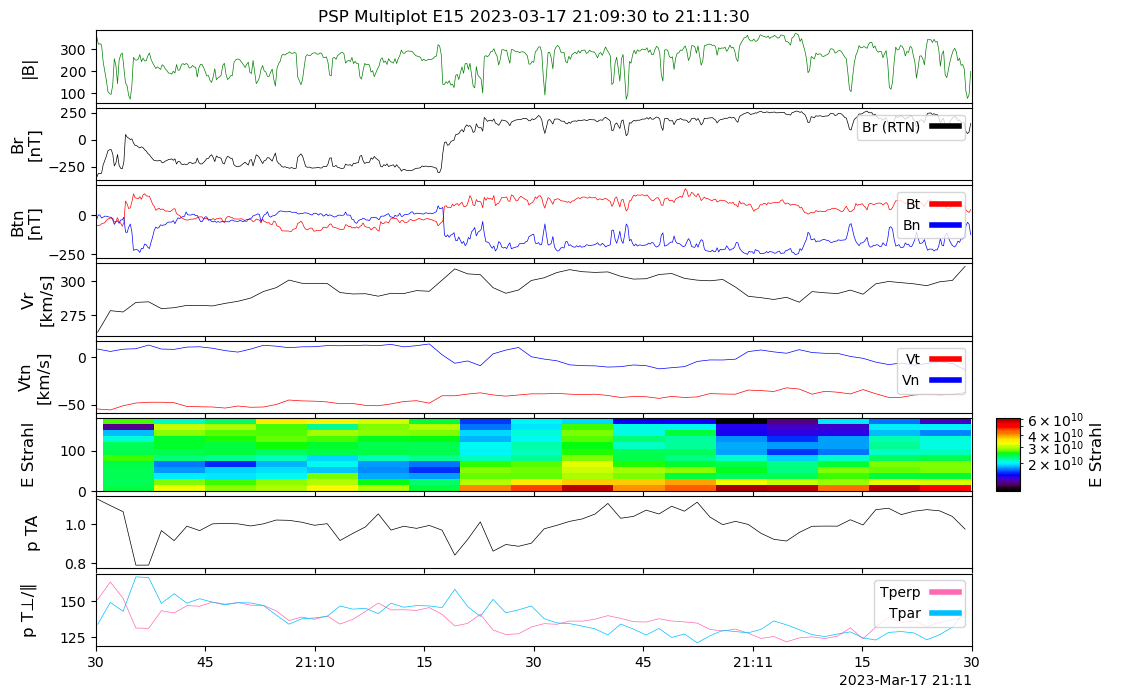

Button(description='Save Multiplot', style=ButtonStyle())

Button(description='Show Directory', style=ButtonStyle())

In [336]:
global save_dir, trange, trange_start, trange_stop

# rangeStart = '2023/03/16 02:41:00.000'
# rangeStop = '2023/03/16 02:42:00.000'

# # # #Encounter 17 MH
# rangeStart = '2022/02/25 12:30:00.000'
# rangeStop = '2022/02/25 12:34:00.000'

# # # #Encounter 9 MH Zoom
# rangeStart = '2021/08/10 00:33:00.000'
# rangeStop = '2021/08/10 00:37:00.000'

# # # Encounter 10 MH storms Mystery Region
# rangeStart = '2021/11/22 00:30:00.000'
# rangeStop = '2021/11/22 03:30:00.000'

# # Encounter 10 MH storms Mystery Region Zoom
# rangeStart = '2021/11/22 01:27:00.000'
# rangeStop = '2021/11/22 01:42:00.000'

# # # Encounter 15 HCS Crossing
rangeStart = '2023/03/17 21:09:30.000'
rangeStop = '2023/03/17 21:11:30.000'

trange_start = convert_to_trange_format(rangeStart)
trange_stop = convert_to_trange_format(rangeStop)
trange = [trange_start, trange_stop]

# Dictionary of variables and their inclusion status
variables = {
    '|B|': 1,
    'Br': 1,
    'Btn': 1,
    'Vr': 1,
    'Vtn': 1,
    'E Strahl': 1,
    'Proton TA': 1,
    'Proton TperpTpar': 1,
    'proton_EFLUX_VS_ENERGY': 0,
    '|Vsw|': 0,
    'proton_EFLUX_VS_PHI': 0,
    'proton_EFLUX_VS_THETA': 0,
    #'Br Spectrum': 0, Spectrum code is not currently up and running
    #'Bt Spectrum': 0,
    #'Bn Spectrum': 0,
}

# Select and plot the variables with inclusion status 1
selected_vars = [var for var, include in variables.items() if include == 1]

options('Proton TA', 'ytitle', 'p TA')
options('proton_EFLUX_VS_ENERGY', 'ytitle', 'p EFlux/E')
options('Proton TperpTpar', 'ytitle', 'p T⊥/∥')
options('E Strahl', 'ytitle', 'E Strahl')

xlim(trange_start, trange_stop)
#xlim('2023-09-28/06:32:00','2023-09-28/06:45:00') #or select a new sub-range

# Generate the multiplot title
plot_title = set_multiplot_title(trange_start, trange_stop)

# Set the title of the multiplot
tplot_options('title', plot_title)

tplot(selected_vars)

# Display the button to save the plot
save_multiplot_button(trange, selected_vars)
show_directory_button(save_dir)



In [189]:
#Change The Global Save Directory
#Running this code will trigger a pop-up menu that will ask you to specify a directory where you'd like to save your files.
#If you don't see a pop-up check your dock for a bouncing white python page and click that.
#Each time you change this directory you'll need to re-run the cells that generate plots before they'll recognize the new location.
#If this directory is not specified the code will not run properly.

global save_dir
last_dir_file = "last_selected_dir.txt"  # Path to save the last selected directory
save_dir = set_save_directory(last_dir_file)
  # Get the save directory, this c
print('save_dir', save_dir)
show_directory_button(save_dir) # Display the button to show the directory

#👇 Your save directory is confirmed here and you can click the button to see it.

save_dir /Users/robertalexander/Dropbox/__Collaborations/_NASA/__PSP_HCS_MH_Investigation/MH_Investigation_Images/E9_Region_1


Button(description='Show Directory', style=ButtonStyle())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pyspedas
from pyspedas import time_string, time_double
import pytplot
from pytplot import get_data, store_data, options, tplot
import datetime
import bisect

# Define some constants and thresholds for MH detection
DEPTH_THRESHOLD = 0.999  # Define a threshold for the depth of the magnetic hole (relative decrease in B-field)
MIN_DURATION = .01  # Minimum duration of magnetic hole in seconds

def download_mag_data(trange):
    pyspedas.psp.fields(trange=trange, datatype='mag_rtn_4_sa_per_cyc', level='l2', time_clip=True, get_support_data=True)
    split_vec('psp_fld_l2_mag_RTN_4_Sa_per_Cyc')

def detect_magnetic_holes(trange, depth_threshold=DEPTH_THRESHOLD, min_duration=MIN_DURATION):
    # Ensure magnetic data is downloaded
    download_mag_data(trange)
    
    # Retrieve magnetic field data
    b_data = get_data('|B|')
    if b_data is None:
        print("No magnetic field data available for the given time range.")
        return []

    times, b_values = b_data.times, b_data.y

    # Convert to numpy arrays for easier manipulation
    times = np.array(times)
    b_values = np.array(b_values)

    # Find magnetic holes
    mh_indices = []
    mh_depths = []

    i = 0
    while i < len(b_values) - 1:
        # Find a potential start of a magnetic hole
        if b_values[i] > (1 + depth_threshold) * b_values[i + 1]:
            start = i
            while i < len(b_values) - 1 and b_values[i] > (1 + depth_threshold) * b_values[i + 1]:
                i += 1
            end = i
            if time_double(times[end]) - time_double(times[start]) >= min_duration:
                mh_indices.append((start, end))
                depth = (b_values[start] - b_values[end]) / b_values[start]
                mh_depths.append(depth)
        i += 1

    return mh_indices, mh_depths

def plot_magnetic_holes(trange, mh_indices):
    # Retrieve magnetic field data for plotting
    b_data = get_data('|B|')
    times, b_values = b_data.times, b_data.y

    # Plot magnetic field strength
    plt.figure(figsize=(12, 6))
    plt.plot(times, b_values, label='|B|', color='black')

    for start, end in mh_indices:
        plt.axvspan(times[start], times[end], color='red', alpha=0.3)

    plt.xlabel('Time')
    plt.ylabel('Magnetic Field Strength (nT)')
    plt.title('Magnetic Holes Detection')
    plt.legend()
    plt.show()

# Example usage
trange = ['2021-08-10/00:33:00', '2021/08/10 00:37:00.000']
mh_indices, mh_depths = detect_magnetic_holes(trange)

if mh_indices:
    print(f"Detected {len(mh_indices)} magnetic holes:")
    for i, (start, end) in enumerate(mh_indices):
        print(f"Magnetic Hole {i+1}:")
        print(f"  Start: {time_string(start)}")
        print(f"  End: {time_string(end)}")
        print(f"  Depth: {mh_depths[i]:.2f}")

    plot_magnetic_holes(trange, mh_indices)
else:
    print("No magnetic holes detected in the given time range.")


## 5.) Plot Proton VDFs (Note From Robert: Nothing changed from here down)

Go here for full tutorial: https://github.com/jlverniero/PSP_Data_Analysis_Tutorials/blob/main/PSP_SPAN-I_VDF_Plot_Tutorial.ipynb

In [ ]:
import datetime as dt

# Define the function to convert the date string to the desired format
def convert_to_trange_format(date_str):
    date_obj = dt.datetime.strptime(date_str, '%Y/%m/%d %H:%M:%S.%f')
    return date_obj.strftime('%Y-%m-%d/%H:%M:%S')

# My timing code
# Jaye E8 Region Zoomed
# rangeStart = '2021/04/29 08:02:00.000'
# rangeStop = '2021/04/29 08:20:00.000'

# rangeStart = '2022/09/06 17:35:00.000'
# rangeStop = '2022/09/06 17:55:00.000'

# E17 Region
# rangeStart = '2023/09/26 22:15:00.000'
# rangeStop = '2023/09/26 22:30:00.000'

trange = ['2022-09-28/06:35','2021-09-28/06:42']

# rangeStart = '2023/09/28 06:35:00.000'
# rangeStop = '2023/09/28 06:42:00.000'

# Convert rangeStart and rangeStop to the desired format
trange_start = convert_to_trange_format(rangeStart)
trange_stop = convert_to_trange_format(rangeStop)
trange = [trange_start, trange_stop]

print(trange)

# Call the helper function to download and process magnetic field data
# Assuming download_and_process_mag_data is defined elsewhere and returns the converted trange
trange_start, trange_stop = download_and_process_mag_data(rangeStart, rangeStop)

# Set the global variable trange
trange = [trange_start, trange_stop]  # Sets Time Range
# ----/ End My timing Code

# Use the trange in your PySPEDAS call
spi_l2_vars = pyspedas.psp.spi(trange=trange, datatype='spi_sf00_8dx32ex8a', level='l2', time_clip=True, get_support_data=True, varnames=['*'], notplot=True, downloadonly=True)

# Open CDF file
dat = cdflib.CDF(spi_l2_vars[0])

# Print variable names in CDF files
print(dat._get_varnames())
cdf_VDfile = dat

# Check variable formats in CDF file
print(cdf_VDfile)
epoch_ns = cdf_VDfile['Epoch']
theta = cdf_VDfile['THETA']
phi = cdf_VDfile['PHI']
energy = cdf_VDfile['ENERGY']
eflux = cdf_VDfile['EFLUX']
rotMat = cdf_VDfile['ROTMAT_SC_INST']
counts = cdf_VDfile['DATA']

# Convert time
datetime_t0 = dt.datetime(2000, 1, 1, 12, 0, 0)
epoch = cdflib.cdfepoch.to_datetime(cdf_VDfile.varget('Epoch'))


In [77]:
import bisect
import datetime as dt

def convert_time(year, month, day, hour, minute, second):
    # Convert time
    tSlice = dt.datetime(year, month, day, hour, minute, second)
    print('Desired timeslice start:', tSlice)

    # Find span-i index for desired timeslice
    # Ensure epoch contains datetime objects
    tSliceIndex = bisect.bisect_left(epoch, tSlice)
    print('time Index start spi:', tSliceIndex)
    print('Time of closest start data point spi:', epoch[tSliceIndex])

    return tSliceIndex


In [83]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import numpy as np

def plot_spani_vdf(year, month, day, hour, minute, second):
    # Input time, output theta and phi plane VDF plots
    
    # Find index of given time
    tSliceIndex = convert_time(year, month, day, hour, minute, second)
    
    # Access data at that index
    epochSlice = epoch[tSliceIndex]
    thetaSlice = theta[tSliceIndex, :]
    phiSlice = phi[tSliceIndex, :]
    energySlice = energy[tSliceIndex, :]
    efluxSlice = eflux[tSliceIndex, :]
    countsSlice = counts[tSliceIndex, :]
    
    # Reshape data to reflect 8 theta bins, 32 energy bins, and 8 phi bins
    thetaReshaped = thetaSlice.reshape((8, 32, 8))
    phiReshaped = phiSlice.reshape((8, 32, 8))
    energyReshaped = energySlice.reshape((8, 32, 8))
    efluxReshaped = efluxSlice.reshape((8, 32, 8))
    countsReshaped = countsSlice.reshape((8, 32, 8))

    mass_p = 0.010438870  # Proton mass in units eV/c^2 where c = 299792 km/s
    charge_p = 1  # Proton charge in units eV

    # Define VDF
    numberFlux = efluxReshaped / energyReshaped
    vdf = numberFlux * (mass_p ** 2) / ((2E-5) * energyReshaped)

    # Convert to velocity units in each energy channel
    vel = np.sqrt(2 * charge_p * energyReshaped / mass_p)
    vx = vel * np.cos(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vy = vel * np.sin(np.radians(phiReshaped)) * np.cos(np.radians(thetaReshaped))
    vz = vel * np.sin(np.radians(thetaReshaped))

    # Theta is along dimension 0, while phi is along 2
    # First cut through theta
    theta_cut = 0 

    phi_plane = phiReshaped[theta_cut, :, :]
    theta_plane = thetaReshaped[theta_cut, :, :]
    energy_plane = energyReshaped[theta_cut, :, :]
    vel_plane = np.sqrt(2 * charge_p * energy_plane / mass_p)

    df_theta = np.nansum(vdf, axis=0)

    vx_plane_theta = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane_theta = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane_theta = vel_plane * np.sin(np.radians(theta_plane))

    fig, ax = plt.subplots()
    cs = ax.contourf(vx_plane_theta, vz_plane_theta, df_theta, locator=ticker.LogLocator(), cmap=cm.cool)
    cbar = fig.colorbar(cs)
    cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

    ax.set_xlim(-1000, 0)
    ax.set_ylim(-500, 500)
    ax.set_xlabel('$v_x$ km/s')
    ax.set_ylabel('$v_z$ km/s')
    tname = f"{epoch[tSliceIndex].strftime('%y-%m-%d/%H:%M:%S')}"
    ax.set_title('Protons ' + tname, fontsize=12)
    
    # Now repeat for phi dimension
    phi_cut = 1
    
    phi_plane = phiReshaped[:, :, phi_cut]
    theta_plane = thetaReshaped[:, :, phi_cut]
    energy_plane = energyReshaped[:, :, phi_cut]
    vel_plane = np.sqrt(2 * charge_p * energy_plane / mass_p)

    df_phi = np.nansum(vdf, axis=2)

    vx_plane_phi = vel_plane * np.cos(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vy_plane_phi = vel_plane * np.sin(np.radians(phi_plane)) * np.cos(np.radians(theta_plane))
    vz_plane_phi = vel_plane * np.sin(np.radians(theta_plane))

    fig, ax = plt.subplots()
    cs = ax.contourf(np.transpose(vx_plane_phi), np.transpose(vy_plane_phi), np.transpose(df_phi), locator=ticker.LogLocator(), cmap=cm.cool)
    cbar = fig.colorbar(cs)
    cbar.set_label(f'f $(cm^2 \\ s \\ sr \\ eV)^{-1}$')

    ax.set_xlim(-700, 0)
    ax.set_ylim(-200, 500)
    ax.set_xlabel('$v_x$ km/s')
    ax.set_ylabel('$v_y$ km/s')
    ax.set_title('VDF SPAN-I $\\phi$-plane')


In [85]:
print(type(epoch[0]))  # This should print <class 'datetime.datetime'>

import bisect
plot_spani_vdf(2023, 9, 28, 6, 35, 0)
#trange: '2021-04-29/08:02:00', '2021-04-29/08:20:00'

<class 'numpy.datetime64'>
Desired timeslice start: 2023-09-28 06:35:00


TypeError: '<' not supported between instances of 'int' and 'datetime.datetime'

2021-04-29/08:02:00 2021-04-29/08:20:00


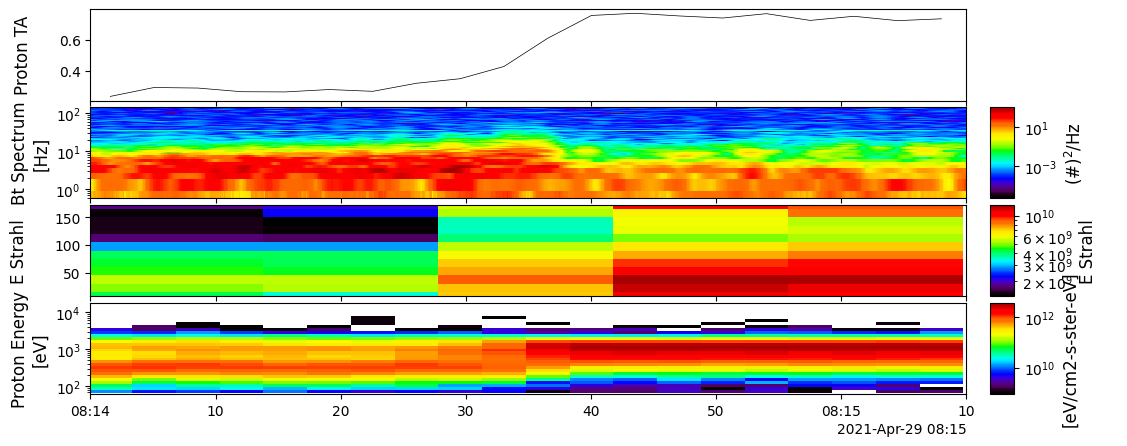

['2021-04-29/08:02:00', '2021-04-29/08:20:00']


In [36]:
# Dictionary of variables and their inclusion status
variables = {
    'Proton TperpTpar': 0,
    'Proton TA': 1,
    'Vr': 0,
    'Vtn': 0,
    'Btn': 0,
    'Br': 0,
    '|B|': 0,
    'Br Spectrum':0,
    'Bt Spectrum':1,
    'Bn Spectrum':0,
    'E Strahl': 1,
    'proton_EFLUX_VS_ENERGY': 1
}

#xlim(trange_start,trange_stop)
xlim('2021-04-29/08:14:00','2021-04-29/08:15:10')
print(trange_start,trange_stop)

# Select and plot the variables with inclusion status 1
selected_vars = [var for var, include in variables.items() if include == 1]

tplot(selected_vars)
print(trange)

## 5.) Check for sufficent SPAN-I field-of-view (FOV)

Go here for full tutorial: https://github.com/jlverniero/PSP_Data_Analysis_Tutorials/blob/main/PSP_SPAN-I_FOV_diagnostic.ipynb

### 5.1) Phi angle coverage:

The first (and perhaps most dominant) effect on SPAN-I data reliabiliy is how much the plasma is cut off by the heat shield. This is mostly in the phi direction of the instrument. To see this, we plot the energy flux in the three planes of the instrument: Energy, Theta (anode), and Phi (look direction).

In [ ]:
#reset full time range
# xlim('2021-01-14','2021-01-21')
tplot(['|B|','proton_EFLUX_VS_ENERGY','proton_EFLUX_VS_THETA','proton_EFLUX_VS_PHI'])

In the fourth panel, we see how much energy flux is captured in each $\phi$ angle bin. To determine "good" coverage by eye, one should observe that there exists a peak in the range of angles, meaning the peak (or core) of the distribution is covered in the phi measurement plane. We also want to make sure this peak is located at the 160 degree mark or lower. Note that the 180 bin will always appear to have lower flux, which may be a deceptive peak.


Anytime, the collapsed VDFs (E, theta, phi), approach the edges of the coverage, we have partial loss of VDF information. Theta and Energy coverage are also an important factor to consider, especially in later encounters.

We may define a rudimentary FOV diagnostic based on the location of the maximum flux in the phi-plane.

In [51]:
#define variables
eflux_phi_data=get_data('proton_EFLUX_VS_PHI')
times_unix=eflux_phi_data.times
eflux = eflux_phi_data.y
phi = eflux_phi_data.v

print(trange)

#determine phi angle with max eflux
max_phi_ind = np.argmax(eflux, axis=1)
max_phi = phi[0, max_phi_ind]

#determine average phi
avg_phi = np.average(eflux,axis=1)

#define fov array
tlen = times_unix.shape[0]
phi_fov=np.ones(tlen)

#set threshold 163.125 degrees
phi_thresh = phi[0,1]

#set fov to 0, meaning reliable, if less than 163.125
for x in range(0,tlen):
    if max_phi[x] < phi_thresh:
        phi_fov[x]=0


['2023-09-28/06:35:00', '2023-09-28/06:42:00']


Now we have array of zeros and ones indicating if the phi coverage is sufficient. We can mark the times with red xs below, where 1 means sufficient, and 0 means insufficient.

In reality, this determination is not quantized or binary. This is a 0th order, HIGHLY rudimentary diagnostic.

26-Jul-24 19:53:04: No data found in the time range: phi_fov


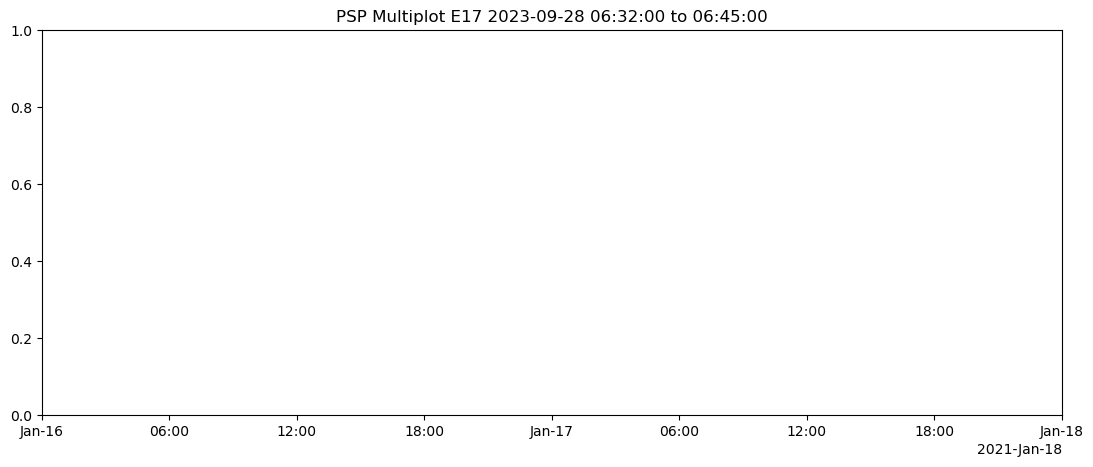

In [53]:
store_data('max_phi',data={'x':times_unix,'y':max_phi})
options('max_phi','color','k')

store_data('phi_fov',data={'x':times_unix,'y':phi_fov})
options('phi_fov','color','r')
options('phi_fov','symbols',True)
options('phi_fov','marker','+')

store_data('EFLUX_VS_PHI_max',data=["proton_EFLUX_VS_PHI","max_phi"])

#tplot(['EFLUX_VS_PHI_max','phi_fov'])
tplot(['phi_fov'])

(Note I am not sure why the colorbar is offset after overplotting, this is most likely a pyspedas bug.)

We can see that the inbound mostly does not have sufficent coverage by the SPAN-I instrument. During these times, over half the VDF is not captured and therefore the plasma measurements are unreliable during these times. In principle, one could then look to SPC during these times, if available. The sweap instrument team is currently working on a joint SPC-SPAN data product and calibration efforts are ongoing.

26-Jul-24 19:45:05: No data found in the time range: proton_EFLUX_VS_PHI
26-Jul-24 19:45:05: No data found in the time range: max_phi
26-Jul-24 19:45:05: No data found in the time range: phi_fov


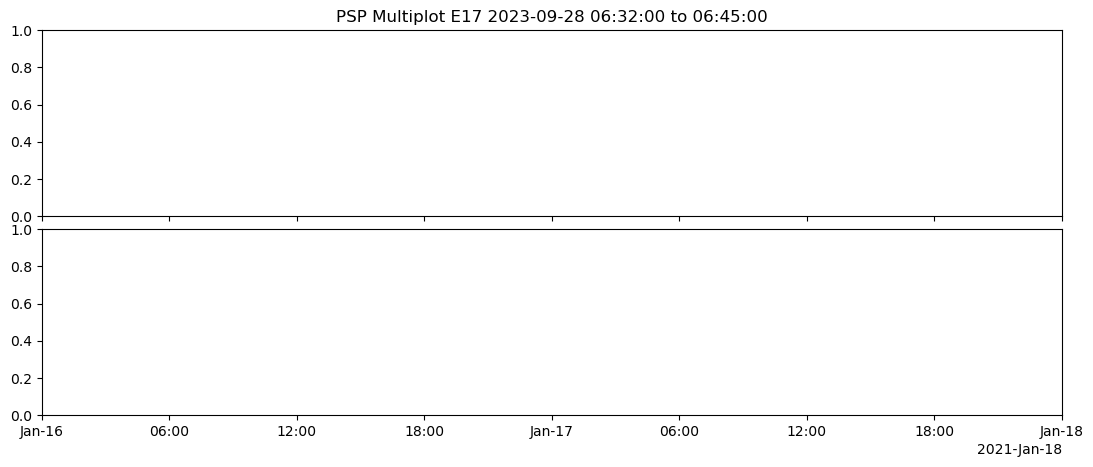

In [33]:
xlim('2021-01-16','2021-01-18')
tplot(['EFLUX_VS_PHI_max','phi_fov'])

We can see that the measurements start to slighly be reliable on the 16th and more on the 17th. 

In general, SPAN-I has better reliability +/- a few days from perihelion.

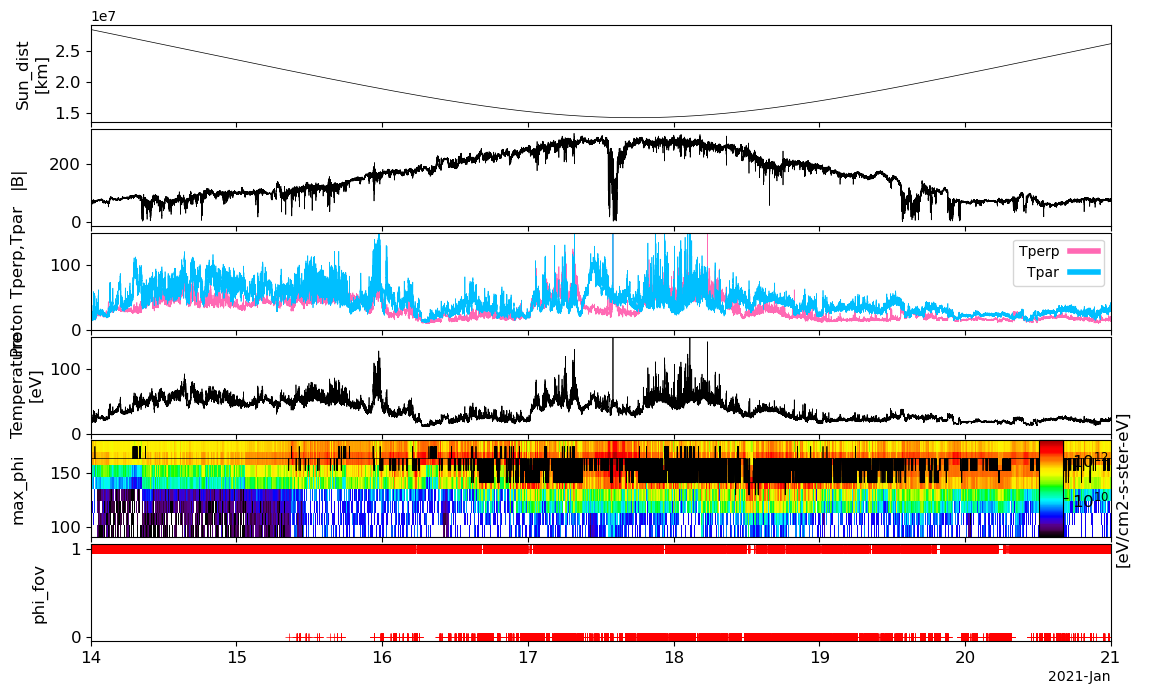

In [42]:
xlim('2021-01-14','2021-01-21')
options('proton_TEMP','yrange',[0,150])
tplot(['proton_SUN_DIST','|B|','Proton TperpTpar','proton_TEMP','EFLUX_VS_PHI_max','phi_fov'])

## 5.2) QTN Comparison


The Quasithermal Noise (QTN) data from the FIELDS instrument is presently the most reliable measurement of density. See Moncuquet et al. (DOI: 10.3847/1538-4365/ab5a84) for more details.

 Since SPAN-I measures partial moments of the VDF, density is highly sensitive to inaccuracies. In addition to the $\phi$ angular coverage assessment described above, the data user is encouraged to compare the SPAN-I measured density to the density derived from QTN. Note that this measurement is also prone to error, and there is currently no agreed upon value of density. Ongoing calibration efforts by the instrument team continue to converge closer to an answer. Below, we show how to compare the QTN and SPAN-I measured density.

Note there is not a defined threshold for offsets, as the answer depends on the physical problem at hand. The user is encouraged to reach out to the SPAN-I instrument team for recommendations if the SPAN-I density in the time period of interest deviates strongly from the QTN.

Future additions to this tutorial will show how to also compare with density measured by SPC.

In [55]:
#note we already downloaded this above, but in case you want to skip here to check FOV first, one can redownload.
qtn_datatype = 'sqtn_rfs_V1V2' #sqtn
qtn_vars = pyspedas.psp.fields(trange=trange, datatype=qtn_datatype, level='l3', time_clip=True,get_support_data=True)

26-Jul-24 19:53:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l3/sqtn_rfs_v1v2/2023/


Using LEVEL=L3


26-Jul-24 19:53:14: No links matching pattern psp_fld_l3_sqtn_rfs_v1v2_20230928_v?.?.cdf found at remote index https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l3/sqtn_rfs_v1v2/2023/


In [57]:
store_data("DENS_compare",data=['proton_DENS','electron_density'])
options('DENS_compare','legend_names',['Np','Ne'])
options('DENS_compare','color',['hotpink','deepskyblue'])

divide('proton_DENS','electron_density','Np/Ne')
options('Np/Ne','ytitle','Np/Ne')
options('Np/Ne','yrange',[1e-2,2])

tplot(['proton_SUN_DIST','|B|','EFLUX_VS_PHI_max','phi_fov','DENS_compare','Np/Ne'])

26-Jul-24 19:53:18: store_data: Pseudovariable DENS_compare component electron_density not found, skipping
26-Jul-24 19:53:18: /opt/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),

26-Jul-24 19:53:18: /opt/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)



KeyError: 'electron_density'

We may observe that devations of SPAN-I measured proton density (Np) and QTN measured electron density (Ne) are most apparent on the inbound. This is the reason why the alpha-proton number density differed from the alpha-electron number density. Depending on context, the reliability of the alpha measurments may be highly contingent on reliability of proton measurements, especially for temperature.

In addition, deviations from QTN do not always coincide with insufficient phi angle coverage (and vice versa). These two diagnostics should be used independantly to assess measurement reliability. However, if your region of interest has both insufficient phi coverage and also strong deviations from QTN, then one needs to excercise extreme caution and spell out all caveats if one uses the SPAN-I measurements during these times. Other considerations to consider, such as magnetic field variability, may be found in the FOV tutorial: https://github.com/jlverniero/PSP_Data_Analysis_Tutorials/blob/main/PSP_SPAN-I_FOV_diagnostic.ipynb

In summary, days far from perihelion most likely do not have reliable proton measurements from SPAN-I. This does not mean that SPAN-I should not be used at all, only that extra caution should be made and one should spell out all caveats before making a scientific claim. For answering physics problems that only require proton measurements on a larger scale, unreliable span measurment times may be cautiously used (as a ballpark lower bound for example). But, for kinetic physics problems that are highly sensitive to measurement uncertainties, it is not recommended to use SPAN-I during unreliable measurement times. 

Note that the reliability of the alpha particle measurements may also be assessed by the same procedure above. As a general rule of thumb, if the protons are unreliable, then so are the alphas (but not always). In addition, the alphas should only in general be trusted if the alpha/proton number density is above 1 percent. Future work will further characterize the alpha reliability.

For optimal scientific interpretation of noteworthy event, the reader is strongly encouraged to contact a member of the instrument team:<br>
Roberto Livi rlivi@berkeley.edu <br>
Ali Rahmati rahmati@berkeley.edu <br>
Davin Larson davin@berkeley.edu <br>

Thank you, and happy exploring :)